In [1]:
## Important Options:
run_epochs = 200
run_model_type = "VAE"

run_save_folder = "../../outputs/experiments_test/syntheticshapes/vae_l2/" 
run_read_data_folder = "../../data/examples_synthetic_shapes/corrupt_level_35_percent/run_1/" # 1 2 3
trust_set_name = "50_samples_per_class" # 5; 10; 25, 50;


In [2]:
%run ../repair_syserr_models/main.py \
    --cuda-on \
    --save-on \
    --output-folder {run_save_folder} \
    --verbose-metrics-epoch \
    --model-type {run_model_type} \
    --number-epochs {run_epochs} \
    --dataset-folder {run_read_data_folder} \
    --use-binary-img \
    --kl-anneal \
    --kl-anneal-start 0.0 \
    --kl-anneal-stop 1.0 \
    --kl-anneal-ratio 0.5 \
    --kl-anneal-delay-epochs 10 \
    --l2-reg 35.0 \
    --trust-set-name {trust_set_name}


Namespace(activation='relu', batch_size=128, cuda_on=True, data_folder='../../data/examples_synthetic_shapes/corrupt_level_35_percent/run_1/', dist_corr_reg=False, dist_corr_reg_coeff=1.0, embedding_size=50, fixed_prior_z_clean=1.0, fixed_prior_z_dirty=5.0, fixed_prior_zy0_sigma=5.0, fixed_prior_zy1_sigma=1.0, kl_anneal=True, kl_anneal_cycles=1, kl_anneal_delay_epochs=10, kl_anneal_ratio=0.5, kl_anneal_start=0.0, kl_anneal_stop=1.0, kl_beta_const=1.0, l2_reg=35.0, latent_dim=15, layer_size=400, learn_z_given_y_priors=False, load_model=False, load_model_path=None, log_interval=50, lr=0.001, mean_eps_z_in=0.0, model_type='VAE', number_epochs=200, output_folder='../../outputs/experiments_test/syntheticshapes/vae_l2/', q_y_x_coeff=1.0, qy_sup_weights=None, reg_delay_n_epochs=5, reg_schedule_ratio=0.5, save_on=True, semi_supervise=False, sigma_eps_z_in=0.1, size_input=784, size_output=784, sup_loss_coeff=0.1, train_on_clean_data=False, trust_set_name='50_samples_per_class', use_batch_norm=F

In [3]:
ls ../../outputs/experiments_test/syntheticshapes/

ccvae/  clsvae/  cvae/  vae_l2/


### Define Paths

In [4]:
# Data folder
file_path_data = run_read_data_folder + "train/"

# Experiment / results folder
model_type = run_model_type
file_path_exper = run_save_folder + model_type + "/"

In [5]:
# Check folder of dataset
!ls {file_path_data}/..

cols_info.json	full  noising_info.json  test  train  validation


In [6]:
with open(file_path_data + "/y_noise_dict.json") as json_file:
    y_noise_dict_train = json.load(json_file)

#trusted_idxs_train = pd.read_csv(file_path_data + "/trusted_idxs.csv").values.flatten()
trusted_idxs_train = pd.read_csv(file_path_data + f"/trusted_idxs_{trust_set_name}.csv").values.flatten()

In [7]:
ls "../../data/examples_synthetic_shapes/corrupt_level_35_percent/run_1/train/"

cells_changed_mtx.csv                  trusted_idxs_25_samples_per_class.csv
changes_summary.csv                    trusted_idxs_50_samples_per_class.csv
data_clean.csv                         trusted_idxs_5_samples_per_class.csv
data_noised.csv                        tuples_changed_mtx.csv
original_idxs.csv                      y_class.csv
trusted_idxs_10_samples_per_class.csv  y_noise_dict.json


### Check VARS on Notebook

In [8]:
whos

Variable               Type             Data/Info
-------------------------------------------------
StandardTrainer        type             <class 'repair_syserr_mod<...>r_utils.StandardTrainer'>
args                   Namespace        Namespace(activation='rel<...>False, y_clean_prior=0.7)
compute_metrics        function         <function compute_metrics at 0x7ffb3d029790>
dict_main_vars         dict             n=53
errno                  module           <module 'errno' (built-in)>
evaluation_phase       function         <function evaluation_phase at 0x7ff9f51543a0>
file_path_data         str              ../../data/examples_synth<...>l_35_percent/run_1/train/
file_path_exper        str              ../../outputs/experiments<...>ntheticshapes/vae_l2/VAE/
frange_cycle_linear    function         <function frange_cycle_linear at 0x7ff9f792b940>
gen_utils              module           <module 'repair_syserr_mo<...>err_models/gen_utils.py'>
json                   module           <module

In [9]:
# debug vars -- from main.py
dict_main_vars.keys()

dict_keys(['args', 'train_loader', 'X_train', 'target_errors_train', 'dataset_obj', 'attributes', 'trusted_mask', 'train_loader_no_shuff', 'valid_loader', 'X_valid', 'target_errors_valid', 'dataset_valid_obj', '_', 'valid_loader_no_shuff', 'test_loader', 'X_test', 'target_errors_test', 'dataset_test_obj', 'test_loader_no_shuff', 'train_clean_loader', 'X_train_clean', 'dataset_obj_train_clean', 'train_clean_loader_no_shuff', 'X_valid_clean', 'dataset_obj_valid_clean', 'valid_clean_loader_no_shuff', 'X_test_clean', 'dataset_obj_test_clean', 'test_clean_loader_no_shuff', 'runin_model', 'model', 'train_optim', 'losses_save', 'kl_anneal', 'kl_beta_n_cycles', 'kl_beta_ratio', 'delay_n_epochs', 'delay_beta_vec', '_delay_n_epochs', 'kl_beta_vec', 'reg_schedule_vec', '_train_loader_used', '_train_loader_no_shuff', '_valid_loader_no_shuff', '_test_loader_no_shuff', '_X_train', '_X_valid', '_X_test', 'epoch', 'kl_beta_val', 'reg_schedule_val', 'folder_output', 'outfile'])

### Load Packages 

In [10]:
import pandas as pd
import numpy as np
import torch
import repair_syserr_models.gen_utils as gen_utils
from repair_syserr_models import VAE
import json

import pprint
import seaborn as sns
from matplotlib import pyplot as plt
import os
import json

### Check Dataset Definitions and Noising

In [11]:
with open(file_path_data + "../noising_info.json") as f:
    dt_defs = json.load(f)
pprint.pprint(dt_defs)

{'name': 'run_1',
 'synth_data': {'defs': {'combs_on': False,
                         'corrupt_prob': 0.35,
                         'n_samples': 5000,
                         'random_state': None},
                'noise_list_trusted': 'regular',
                'type': 'ShapesWithStrips'},
 'test_size': 0.1,
 'train_size': 0.8,
 'trusted_set': {'dataset_size': 5000,
                 'frac_trusted': None,
                 'mc_mode': 'fixed_number',
                 'min_coverage': True,
                 'n_classes': 8,
                 'percentages': [0.8, 1.6, 4.0, 8.0],
                 'samples_fixed': [5, 10, 25, 50],
                 'total_points': [40, 80, 200, 400],
                 'use_labels': 'joint_classes',
                 'y_class_on': True,
                 'y_noise_lists_on': True},
 'valid_size': 0.1}


In [12]:
with open(file_path_data + "../cols_info.json") as f:
    col_defs = json.load(f)
pprint.pprint(col_defs)

{'cat_cols_names': [],
 'dataset_type': 'image',
 'image_defs': {'channel_type': 'gray',
                'channels': [],
                'num_channels': 1,
                'size': [28, 28]},
 'num_cols_names': ['pixel_0',
                    'pixel_1',
                    'pixel_2',
                    'pixel_3',
                    'pixel_4',
                    'pixel_5',
                    'pixel_6',
                    'pixel_7',
                    'pixel_8',
                    'pixel_9',
                    'pixel_10',
                    'pixel_11',
                    'pixel_12',
                    'pixel_13',
                    'pixel_14',
                    'pixel_15',
                    'pixel_16',
                    'pixel_17',
                    'pixel_18',
                    'pixel_19',
                    'pixel_20',
                    'pixel_21',
                    'pixel_22',
                    'pixel_23',
                    'pixel_24',
                   

### Load Datasets

In [13]:

# train
train_loader, X_train, target_errors_train, dataset_obj, attributes, trusted_mask = gen_utils.load_data(args.data_folder, 
                                                                                                        args.batch_size,
                                                                                                        is_train=True,
                                                                                                        get_data_idxs=True,
                                                                                                        semi_sup_data=True,
                                                                                                        use_binary_img=True,
                                                                                                        trust_set_name=trust_set_name)
    

# Dynamic options for dataset_obj (from args)
dataset_obj.use_binary_img = args.use_binary_img


# test
test_loader, X_test, target_errors_test, _, _ = gen_utils.load_data(args.data_folder, 
                                                                    args.batch_size, 
                                                                    is_train=False,
                                                                    use_binary_img=True)

# -> clean versions for evaluation
_, X_train_clean, _, _, _ = gen_utils.load_data(args.data_folder, 
                                                args.batch_size,
                                                is_train=True, 
                                                is_clean=True, 
                                                stdize_dirty=True,
                                                use_binary_img=True)

_, X_test_clean, _, _, _ = gen_utils.load_data(args.data_folder, 
                                               args.batch_size, 
                                               is_train=False,
                                               is_clean=True, 
                                               stdize_dirty=True,
                                               use_binary_img=True)


In [14]:
X_train_clean

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [15]:
args.data_folder

'../../data/examples_synthetic_shapes/corrupt_level_35_percent/run_1/'

In [16]:
y_noise_instance_train = target_errors_train.any(dim=1).numpy()
y_noise_pixels_train = target_errors_train.numpy().reshape(-1,28,28)

y_targets_mdl = ~ torch.from_numpy(y_noise_instance_train).view(-1,1)

x_train_orig = X_train.view(-1,28,28).numpy()
x_train_clean_orig = X_train_clean.view(-1,28,28).numpy()


In [17]:
X_train_clean.view(-1,28,28)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

### Load Model

In [18]:
vae_mdl = eval(model_type).VAE(dataset_obj, args)
file_path_model = file_path_exper + "model_params.pth"
vae_mdl.load_state_dict(torch.load(file_path_model))
vae_mdl.eval()

VAE(
  (activ): ReLU()
  (var_q_z): encodeMVNDiag(
    (torso_encoder): baseEncoder(
      (activ): ReLU()
      (feat_embedd): ModuleList()
      (mod_fw_seq): Sequential(
        (fc_0): Linear(in_features=784, out_features=200, bias=True)
        (activ_0): ReLU()
        (fc_1): Linear(in_features=200, out_features=100, bias=True)
        (activ_1): ReLU()
        (fc_2): Linear(in_features=100, out_features=50, bias=True)
        (activ_2): ReLU()
      )
    )
    (param_nn): GaussDiagDistModule(
      (mu): modSeq(
        (mods_list): ModuleList(
          (0): baseEncoder(
            (activ): ReLU()
            (feat_embedd): ModuleList()
            (mod_fw_seq): Sequential(
              (fc_0): Linear(in_features=784, out_features=200, bias=True)
              (activ_0): ReLU()
              (fc_1): Linear(in_features=200, out_features=100, bias=True)
              (activ_1): ReLU()
              (fc_2): Linear(in_features=100, out_features=50, bias=True)
              (ac

### Load Results from Folder

In [19]:
file_path_exper

'../../outputs/experiments_test/syntheticshapes/vae_l2/VAE/'

In [20]:
df_train_metrics = pd.read_csv(file_path_exper + "train_epochs_data.csv")
df_valid_metrics = pd.read_csv(file_path_exper + "validation_epochs_data.csv")
df_test_metrics = pd.read_csv(file_path_exper + "test_epochs_data.csv")

In [21]:
!ls {file_path_exper}

args_run.json			train_error_repair_features.csv
model_params.pth		trusted_auc_features.csv
test_auc_features.csv		trusted_avpr_features.csv
test_avpr_features.csv		trusted_epochs_data.csv
test_epochs_data.csv		trusted_error_repair_features.csv
test_error_repair_features.csv	validation_auc_features.csv
train_auc_features.csv		validation_avpr_features.csv
train_avpr_features.csv		validation_epochs_data.csv
train_epochs_data.csv		validation_error_repair_features.csv


In [22]:
df_train_metrics

Epochs  Avg. TOTAL_LOSS  Avg. LOSS_ELBO  Avg. LOSS_SUP    Avg. NLL  \
0         1       333.980250      333.980250            0.0  333.980250   
1         2       310.482927      310.482927            0.0  310.482927   
2         3       282.326377      282.326377            0.0  282.326377   
3         4       260.092672      260.092672            0.0  260.092672   
4         5       253.446224      253.446224            0.0  253.446224   
..      ...              ...             ...            ...         ...   
195     196        78.266906       78.266906            0.0   60.525608   
196     197        77.639220       77.639220            0.0   59.899870   
197     198        77.050958       77.050958            0.0   59.943139   
198     199        78.002468       78.002468            0.0   60.221286   
199     200        77.454521       77.454521            0.0   59.506025   

     Avg. KLD_TOT  Avg. KLD_Z  AUC Cell nll score  AVPR Cell nll score  \
0        1.062388    1.062388            0.844445             0.426105   
1        0.761103    0.761103            0.868250             0.453511   
2        4.925642    4.925642            0.870387             0.467050   
3       19.175324   19.175324            0.887626             0.477996   
4       31.056272   31.056272            0.879926             0.506389   
..            ...         ...                 ...                  ...   
195     17.741297   17.741297            0.991636             0.925684   
196     17.739350   17.739350            0.994241             0.944707   
197     17.107820   17.107820            0.992608             0.931544   
198     17.781182   17.781182            0.993026             0.936132   
199     17.948497   17.948497            0.992406             0.924671   

     AUC Row nll score  AVPR Row nll score  AUC Row class_y score  \
0             0.576116            0.401629                  -10.0   
1             0.609255            0.424923                  -10.0   
2             0.601423            0.420458                  -10.0   
3             0.609390            0.429242                  -10.0   
4             0.613298            0.429095                  -10.0   
..                 ...                 ...                    ...   
195           0.938015            0.857800                  -10.0   
196           0.935888            0.854070                  -10.0   
197           0.948574            0.878968                  -10.0   
198           0.945347            0.873067                  -10.0   
199           0.942723            0.872086                  -10.0   

     AVPR Row class_y score  Error lower-bound on dirty pos  \
0                     -10.0                        0.159458   
1                     -10.0                        0.148876   
2                     -10.0                        0.123725   
3                     -10.0                        0.115633   
4                     -10.0                        0.121866   
..                      ...                             ...   
195                   -10.0                        0.032652   
196                   -10.0                        0.029279   
197                   -10.0                        0.030217   
198                   -10.0                        0.030630   
199                   -10.0                        0.031370   

     Error upper-bound on dirty pos  Error repair on dirty pos  \
0                               1.0                   0.157667   
1                               1.0                   0.149790   
2                               1.0                   0.127437   
3                               1.0                   0.120284   
4                               1.0                   0.128434   
..                              ...                        ...   
195                             1.0                   0.048037   
196                             1.0                   0.044629   
197                             1.0

In [23]:
df_valid_metrics

Epochs  Avg. TOTAL_LOSS  Avg. LOSS_ELBO  Avg. LOSS_SUP    Avg. NLL  \
0         1       334.725273      334.725273            0.0  334.725273   
1         2       311.644375      311.644375            0.0  311.644375   
2         3       284.951898      284.951898            0.0  284.951898   
3         4       261.660008      261.660008            0.0  261.660008   
4         5       255.362930      255.362930            0.0  255.362930   
..      ...              ...             ...            ...         ...   
195     196        79.872113       79.872113            0.0   62.247488   
196     197        79.235004       79.235004            0.0   61.614859   
197     198        78.635289       78.635289            0.0   61.625112   
198     199        79.260563       79.260563            0.0   61.561981   
199     200        79.059650       79.059650            0.0   61.174246   

     Avg. KLD_TOT  Avg. KLD_Z  AUC Cell nll score  AVPR Cell nll score  \
0        1.044156    1.044156            0.843257             0.444906   
1        0.755720    0.755720            0.870814             0.476916   
2        4.792555    4.792555            0.872502             0.488486   
3       18.474845   18.474845            0.892869             0.499668   
4       29.489024   29.489024            0.881551             0.522994   
..            ...         ...                 ...                  ...   
195     17.624626   17.624626            0.991697             0.926625   
196     17.620143   17.620143            0.994164             0.944162   
197     17.010176   17.010176            0.993228             0.934591   
198     17.698582   17.698582            0.992978             0.936576   
199     17.885403   17.885403            0.992914             0.926144   

     AUC Row nll score  AVPR Row nll score  AUC Row class_y score  \
0             0.528681            0.372627                  -10.0   
1             0.571283            0.398177                  -10.0   
2             0.560267            0.384966                  -10.0   
3             0.577433            0.403862                  -10.0   
4             0.604742            0.433609                  -10.0   
..                 ...                 ...                    ...   
195           0.935152            0.844175                  -10.0   
196           0.932923            0.846690                  -10.0   
197           0.945383            0.862906                  -10.0   
198           0.941800            0.864862                  -10.0   
199           0.935258            0.851094                  -10.0   

     AVPR Row class_y score  Error lower-bound on dirty pos  \
0                     -10.0                        0.159072   
1                     -10.0                        0.148039   
2                     -10.0                        0.121227   
3                     -10.0                        0.111219   
4                     -10.0                        0.119501   
..                      ...                             ...   
195                   -10.0                        0.030767   
196                   -10.0                        0.027303   
197                   -10.0                        0.027382   
198                   -10.0                        0.028676   
199                   -10.0                        0.028459   

     Error upper-bound on dirty pos  Error repair on dirty pos  \
0                               1.0                   0.157295   
1                               1.0                   0.148895   
2                               1.0                   0.125029   
3                               1.0                   0.115199   
4                               1.0                   0.126001   
..                              ...                        ...   
195                             1.0                   0.045110   
196                             1.0                   0.042144   
197                             1.0

In [24]:
df_test_metrics

Epochs  Avg. TOTAL_LOSS  Avg. LOSS_ELBO  Avg. LOSS_SUP    Avg. NLL  \
0         1       334.725273      334.725273            0.0  334.725273   
1         2       311.644375      311.644375            0.0  311.644375   
2         3       284.951898      284.951898            0.0  284.951898   
3         4       261.660008      261.660008            0.0  261.660008   
4         5       255.362930      255.362930            0.0  255.362930   
..      ...              ...             ...            ...         ...   
195     196        79.872113       79.872113            0.0   62.247488   
196     197        79.235004       79.235004            0.0   61.614859   
197     198        78.635289       78.635289            0.0   61.625112   
198     199        79.260563       79.260563            0.0   61.561981   
199     200        79.059650       79.059650            0.0   61.174246   

     Avg. KLD_TOT  Avg. KLD_Z  AUC Cell nll score  AVPR Cell nll score  \
0        1.044156    1.044156            0.843257             0.444906   
1        0.755720    0.755720            0.870814             0.476916   
2        4.792555    4.792555            0.872502             0.488486   
3       18.474845   18.474845            0.892869             0.499668   
4       29.489024   29.489024            0.881551             0.522994   
..            ...         ...                 ...                  ...   
195     17.624626   17.624626            0.991697             0.926625   
196     17.620143   17.620143            0.994164             0.944162   
197     17.010176   17.010176            0.993228             0.934591   
198     17.698582   17.698582            0.992978             0.936576   
199     17.885403   17.885403            0.992914             0.926144   

     AUC Row nll score  AVPR Row nll score  AUC Row class_y score  \
0             0.528681            0.372627                  -10.0   
1             0.571283            0.398177                  -10.0   
2             0.560267            0.384966                  -10.0   
3             0.577433            0.403862                  -10.0   
4             0.604742            0.433609                  -10.0   
..                 ...                 ...                    ...   
195           0.935152            0.844175                  -10.0   
196           0.932923            0.846690                  -10.0   
197           0.945383            0.862906                  -10.0   
198           0.941800            0.864862                  -10.0   
199           0.935258            0.851094                  -10.0   

     AVPR Row class_y score  Error lower-bound on dirty pos  \
0                     -10.0                        0.159072   
1                     -10.0                        0.148039   
2                     -10.0                        0.121227   
3                     -10.0                        0.111219   
4                     -10.0                        0.119501   
..                      ...                             ...   
195                   -10.0                        0.030767   
196                   -10.0                        0.027303   
197                   -10.0                        0.027382   
198                   -10.0                        0.028676   
199                   -10.0                        0.028459   

     Error upper-bound on dirty pos  Error repair on dirty pos  \
0                               1.0                   0.157295   
1                               1.0                   0.148895   
2                               1.0                   0.125029   
3                               1.0                   0.115199   
4                               1.0                   0.126001   
..                              ...                        ...   
195                             1.0                   0.045110   
196                             1.0                   0.042144   
197                             1.0

In [25]:
n_epochs = df_train_metrics.shape[0]
epochs_range = list(range(1,n_epochs+1))

### Train Dataset Final Results

In [26]:
# Train final results
df_train_metrics.loc[n_epochs-1,:]

Epochs                                      200.000000
Avg. TOTAL_LOSS                              77.454521
Avg. LOSS_ELBO                               77.454521
Avg. LOSS_SUP                                 0.000000
Avg. NLL                                     59.506025
Avg. KLD_TOT                                 17.948497
Avg. KLD_Z                                   17.948497
AUC Cell nll score                            0.992406
AVPR Cell nll score                           0.924671
AUC Row nll score                             0.942723
AVPR Row nll score                            0.872086
AUC Row class_y score                       -10.000000
AVPR Row class_y score                      -10.000000
Error lower-bound on dirty pos                0.031370
Error upper-bound on dirty pos                1.000000
Error repair on dirty pos                     0.046547
Error repair on clean pos                     0.016148
Error repair on clean pos - dirty points      0.017476
Name: 199,

In [27]:
# Validation final results
df_valid_metrics.loc[n_epochs-1,:]

Epochs                                      200.000000
Avg. TOTAL_LOSS                              79.059650
Avg. LOSS_ELBO                               79.059650
Avg. LOSS_SUP                                 0.000000
Avg. NLL                                     61.174246
Avg. KLD_TOT                                 17.885403
Avg. KLD_Z                                   17.885403
AUC Cell nll score                            0.992914
AVPR Cell nll score                           0.926144
AUC Row nll score                             0.935258
AVPR Row nll score                            0.851094
AUC Row class_y score                       -10.000000
AVPR Row class_y score                      -10.000000
Error lower-bound on dirty pos                0.028459
Error upper-bound on dirty pos                1.000000
Error repair on dirty pos                     0.043386
Error repair on clean pos                     0.017043
Error repair on clean pos - dirty points      0.018108
Name: 199,

### Test Dataset Final Results

In [28]:
# Train final results
df_test_metrics.loc[n_epochs-1,:]

Epochs                                      200.000000
Avg. TOTAL_LOSS                              79.059650
Avg. LOSS_ELBO                               79.059650
Avg. LOSS_SUP                                 0.000000
Avg. NLL                                     61.174246
Avg. KLD_TOT                                 17.885403
Avg. KLD_Z                                   17.885403
AUC Cell nll score                            0.992914
AVPR Cell nll score                           0.926144
AUC Row nll score                             0.935258
AVPR Row nll score                            0.851094
AUC Row class_y score                       -10.000000
AVPR Row class_y score                      -10.000000
Error lower-bound on dirty pos                0.028459
Error upper-bound on dirty pos                1.000000
Error repair on dirty pos                     0.043386
Error repair on clean pos                     0.017043
Error repair on clean pos - dirty points      0.018108
Name: 199,

## PLOTS TRAIN DATASET

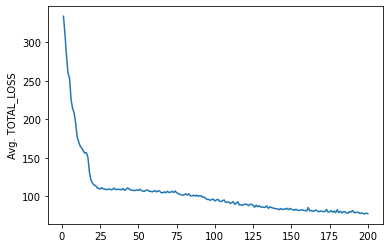

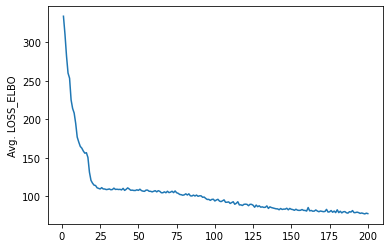

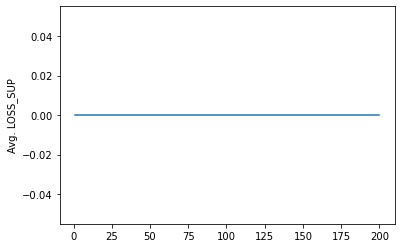

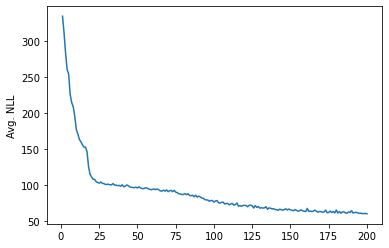

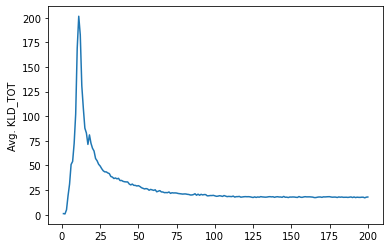

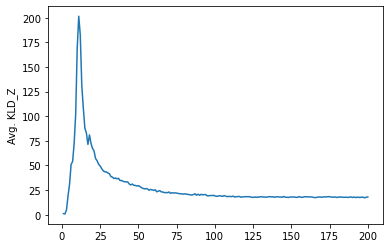

In [29]:
# Plots for losses
for col_name in df_train_metrics.columns:
    if "Avg. " in col_name:
        sns.lineplot(x=epochs_range,y=df_train_metrics[col_name])
        plt.show()

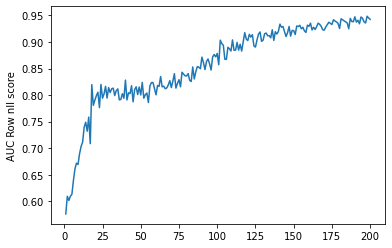

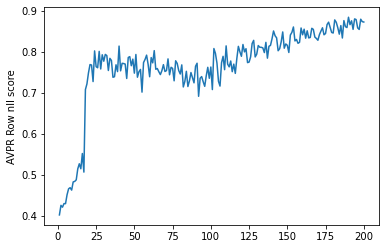

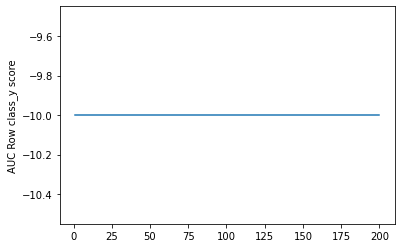

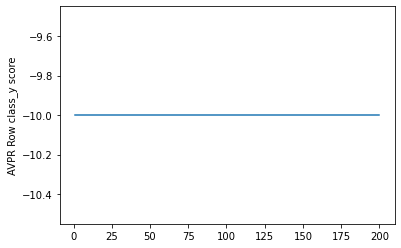

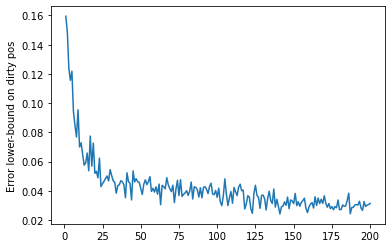

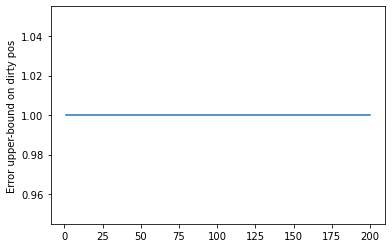

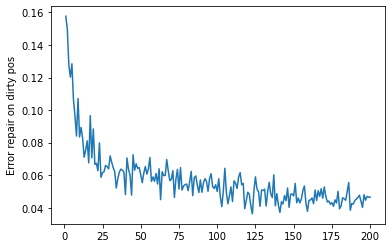

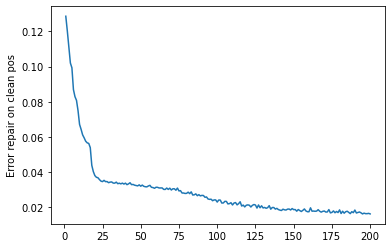

In [30]:
# Plots for classification and repair metrics
list_plot_custom = ["AUC Row nll score", "AVPR Row nll score", 
                    "AUC Row class_y score", "AVPR Row class_y score",
                    "Error lower-bound on dirty pos", "Error upper-bound on dirty pos",
                    "Error repair on dirty pos", "Error repair on clean pos"]

for col_name in list_plot_custom:
    sns.lineplot(x=epochs_range,y=df_train_metrics[col_name])
    plt.show()

### Plot Validation -- Losses

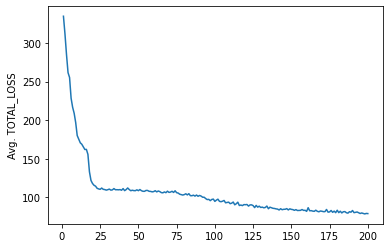

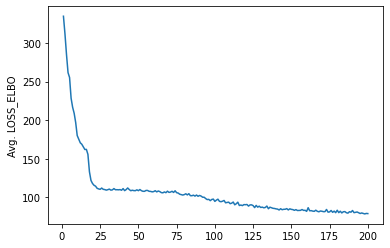

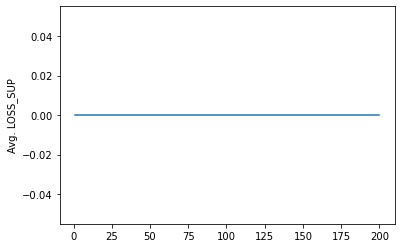

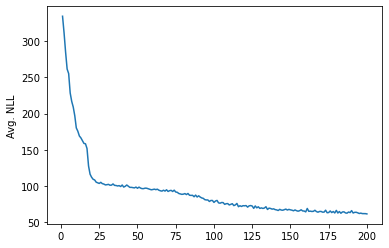

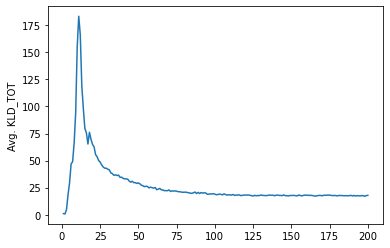

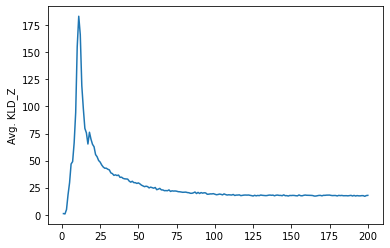

In [31]:
# Plots for losses
for col_name in df_valid_metrics.columns:
    if "Avg. " in col_name:
        sns.lineplot(x=epochs_range,y=df_valid_metrics[col_name])
        plt.show()

### Plot Test -- Losses

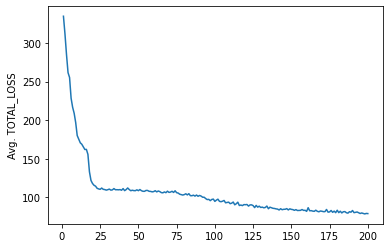

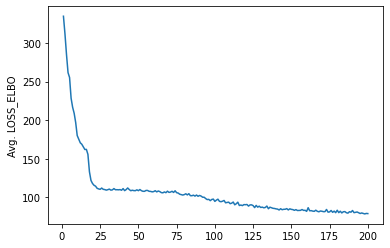

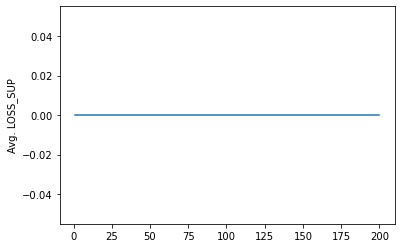

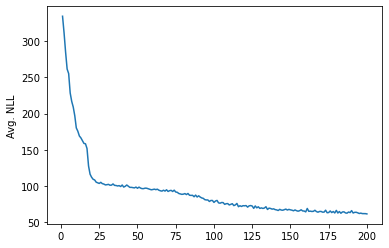

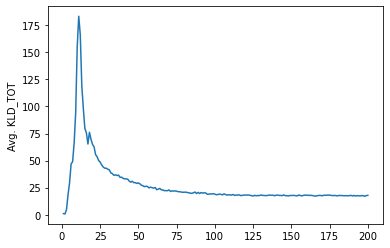

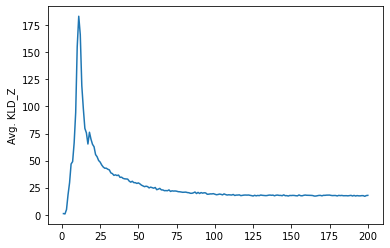

In [32]:
# Plots for losses
for col_name in df_test_metrics.columns:
    if "Avg. " in col_name:
        sns.lineplot(x=epochs_range,y=df_test_metrics[col_name])
        plt.show()

### Get Recons, Latent Space, etc

In [33]:
vae_p_params_xd, vae_q_params, vae_q_samples, _ = vae_mdl(X_train)
recons_train = vae_p_params_xd['recon']['x'].cpu().detach().numpy()
z_train_clean = vae_q_params['z']['mu'].detach().cpu().numpy()


In [34]:
# Show mu and covariance values

z_train_mu = vae_q_params['z']['mu'].detach().cpu().numpy()
z_train_var = np.exp(vae_q_params['z']['logvar'].detach().cpu().numpy())

print("median of variances (per dim), clean: \n {} \n".format(np.median(z_train_var, axis=0)))
print("median of means (per dim), clean: \n {} \n".format(np.median(z_train_mu, axis=0)))


median of variances (per dim), clean: 
 [0.02479121 0.9882168  1.004257   1.003597   0.01064193 0.313775
 1.0139604  0.9885658  0.9942275  0.00779952 1.0029573  0.00861151
 0.98805916 0.08110315 0.9905666 ] 

median of means (per dim), clean: 
 [ 1.7331686e+00  8.6971410e-03  6.0193567e-04 -4.2973110e-03
  1.0031344e+00 -8.1273186e-01 -3.5062726e-04 -1.5161345e-02
  9.7830417e-03  6.3410503e-01 -9.9554856e-04  7.7304024e-01
  6.0491143e-03  1.2724159e+00  1.7147252e-02] 



### Recons

In [35]:
recon_imgs_train = recons_train.reshape(-1,28,28)

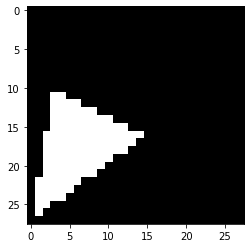

In [36]:
# Show image from train dataset

plt.imshow(x_train_orig[546], cmap="gray",)

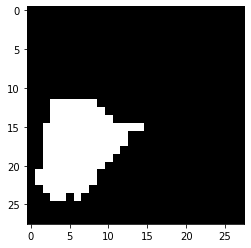

In [37]:
# Show image reconstruction from VAE model

plt.imshow(np.around(recon_imgs_train[546]), cmap="gray", )

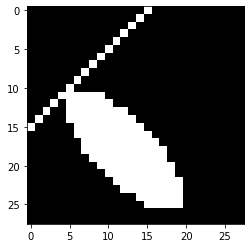

In [38]:
# Show image from train dataset

plt.imshow(x_train_orig[540], cmap="gray",)

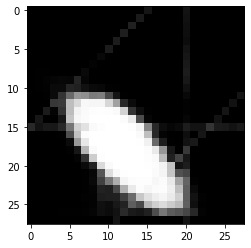

In [39]:
# Show image reconstruction from VAE model

plt.imshow(recon_imgs_train[540], cmap="gray",)

### Show Clean Datapoints at Random

y_noise: 0


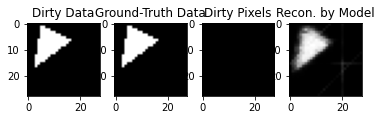

y_noise: 0


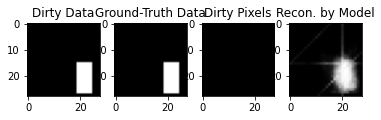

y_noise: 0


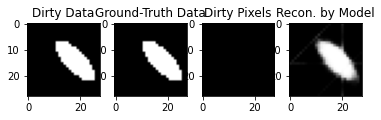

y_noise: 0


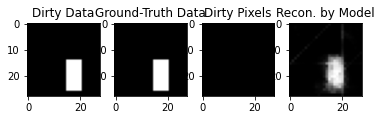

y_noise: 0


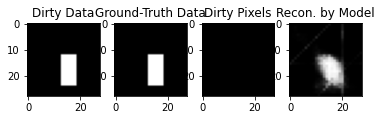

y_noise: 0


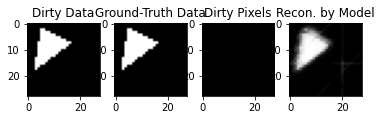

y_noise: 0


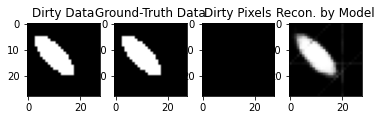

y_noise: 0


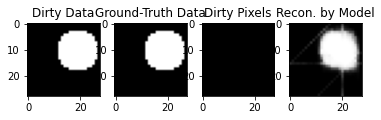

y_noise: 0


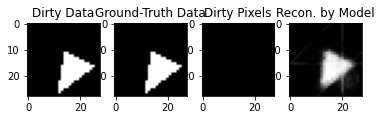

y_noise: 0


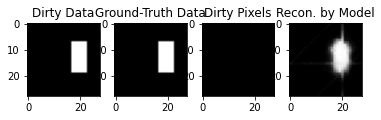

y_noise: 0


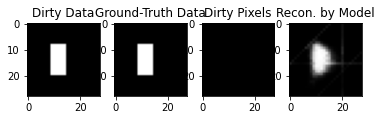

y_noise: 0


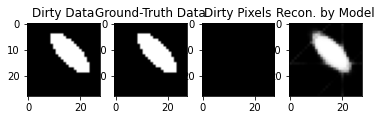

y_noise: 0


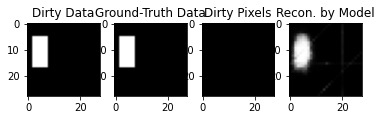

y_noise: 0


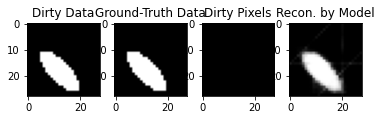

y_noise: 0


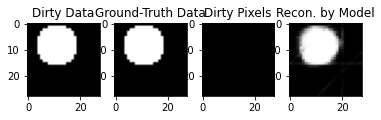

y_noise: 0


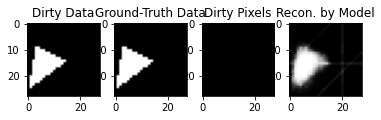

y_noise: 0


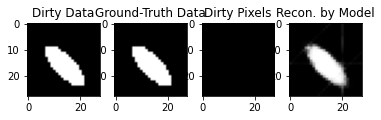

y_noise: 0


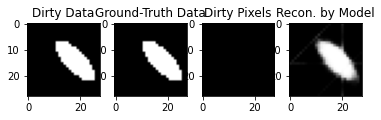

y_noise: 0


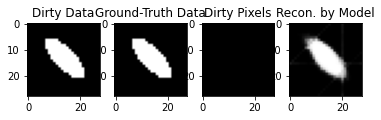

y_noise: 0


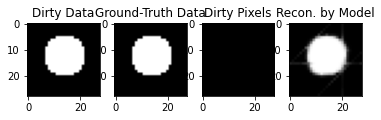

y_noise: 0


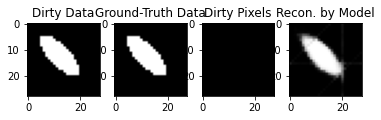

y_noise: 0


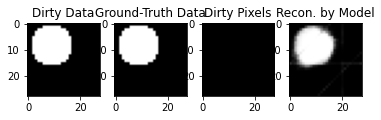

y_noise: 0


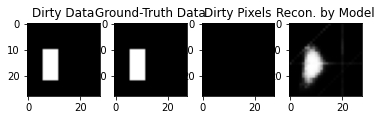

y_noise: 0


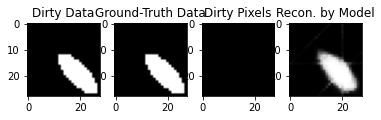

y_noise: 0


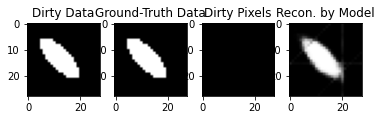

In [40]:
max_imgs_show = 25
y_noise_idxs_train = np.where(~y_noise_instance_train)[0]
some_idxs = np.random.permutation(y_noise_idxs_train)[:max_imgs_show]
# y_noise -- 1 if instance dirty; 0 if instance clean. (NOTE: inverted meaning in generative model)
    
for idx in some_idxs:
    print("y_noise: {}".format(int(y_noise_instance_train[idx])))
    fig, ax = plt.subplots(1,4)
    ax[0].imshow(x_train_orig[idx,...], cmap="gray", ) # vmin=0.0, vmax=1.0
    ax[0].set_title("Dirty Data")
    ax[1].imshow(x_train_clean_orig[idx,...], cmap="gray", ) # vmin=0.0, vmax=1.0
    ax[1].set_title("Ground-Truth Data")
    ax[2].imshow(y_noise_pixels_train[idx,...], cmap="gray", ) # vmin=0.0, vmax=1.0
    ax[2].set_title("Dirty Pixels")
    #ax[3].imshow(recon_imgs_train[idx,...], cmap="gray",) #  vmin=0.0, vmax=1.0
    ax[3].imshow(recon_imgs_train[idx,...], cmap="gray",) #  vmin=0.0, vmax=1.0
    ax[3].set_title("Recon. by Model")
    plt.show()


### Show Dirty Datapoints at Random

y_noise: 1


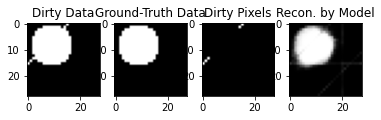

y_noise: 1


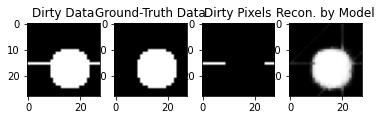

y_noise: 1


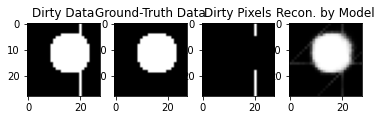

y_noise: 1


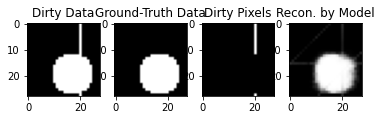

y_noise: 1


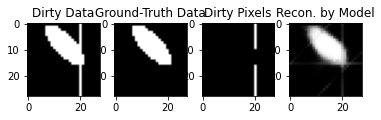

y_noise: 1


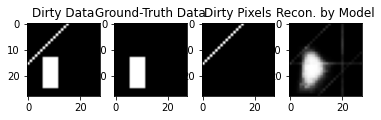

y_noise: 1


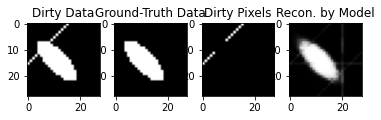

y_noise: 1


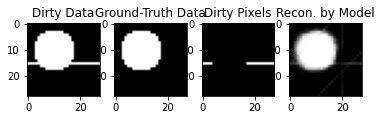

y_noise: 1


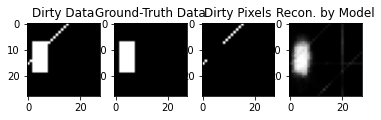

y_noise: 1


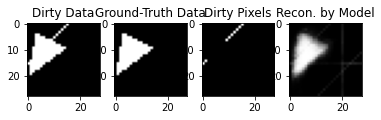

y_noise: 1


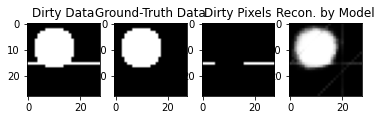

y_noise: 1


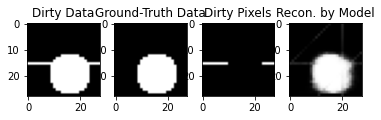

y_noise: 1


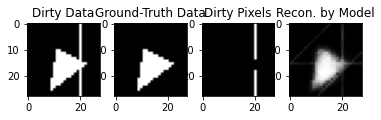

y_noise: 1


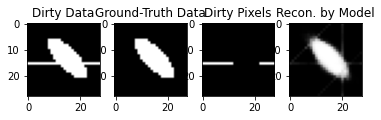

y_noise: 1


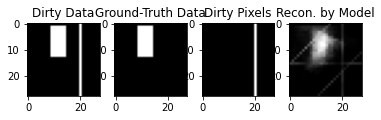

y_noise: 1


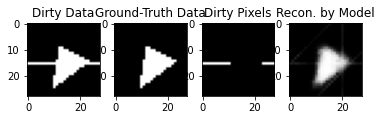

y_noise: 1


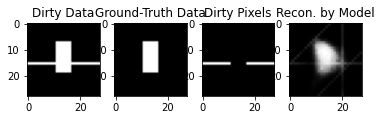

y_noise: 1


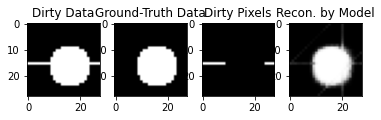

y_noise: 1


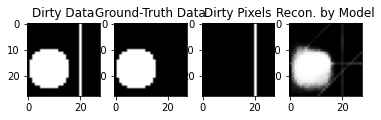

y_noise: 1


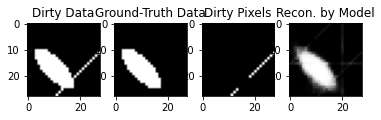

y_noise: 1


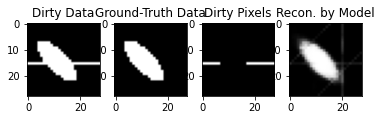

y_noise: 1


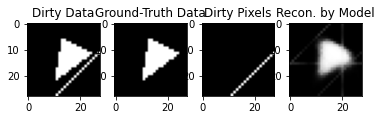

y_noise: 1


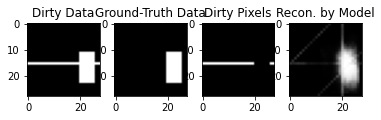

y_noise: 1


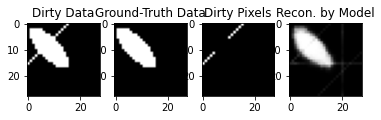

y_noise: 1


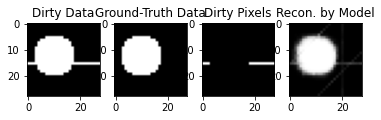

In [41]:
max_imgs_show = 25
y_noise_idxs_train = np.where(y_noise_instance_train)[0]
some_idxs = np.random.permutation(y_noise_idxs_train)[:max_imgs_show]
# y_noise -- 1 if instance dirty; 0 if instance clean. (NOTE: inverted meaning in generative model)
    
for idx in some_idxs:
    print("y_noise: {}".format(int(y_noise_instance_train[idx])))
    fig, ax = plt.subplots(1,4)
    ax[0].imshow(x_train_orig[idx,...], cmap="gray", ) # vmin=0.0, vmax=1.0
    ax[0].set_title("Dirty Data")
    ax[1].imshow(x_train_clean_orig[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[1].set_title("Ground-Truth Data")
    ax[2].imshow(y_noise_pixels_train[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[2].set_title("Dirty Pixels")
    ax[3].imshow(recon_imgs_train[idx,...], cmap="gray",) #  vmin=0.0, vmax=1.0
    #ax[3].imshow(recon_imgs_train[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[3].set_title("Recon. by Model")
    plt.show()



### Show per noise type images: y_noise_lists or y_noise_dict


Noise Tag: 0
Noise Indices: 
[1074, 2486, 847, 3208, 1286, 1959, 3241, 585, 2609, 223, 1834, 3804, 1618, 3708, 163, 1282, 569, 3417, 2556, 3003, 2868, 3866, 171, 2444, 3327, 3933, 3380, 496, 3591, 1448, 2391, 3229, 3073, 602, 2485, 3833, 3766, 3415, 2189, 1189, 2613, 774, 1218, 2408, 1429, 3566, 2383, 2219, 1782, 1810, 769, 977, 3869, 436, 1907, 1110, 2354, 2791, 175, 1970, 717, 427, 755, 47, 1625, 2283, 3928, 472, 725, 2826, 443, 1470, 1307, 3691, 2013, 1938, 198, 3576, 3279, 2578, 3340, 1542, 703, 1956, 1745, 694, 2946, 1871, 1386, 3194, 1626, 2418, 2123, 2345, 2461, 927, 2366, 1924, 2014, 3196, 2061, 3794, 3474, 2340, 2016, 1923, 1571, 3632, 1979, 1040, 425, 3800, 3040, 3526, 1574, 2691, 621, 3549, 946, 3002, 1479, 1531, 3999, 2441, 3106, 1853, 517, 3359, 1936, 1182, 3363, 3376, 971, 405, 916, 2508, 1930, 2322, 1785, 508, 779, 914, 1195, 3533, 1647, 1301, 1905, 1926, 1294, 2639, 2160, 2173, 2943, 3382, 1848, 85, 2832, 2930, 481, 1248, 3521, 3925, 2845, 534, 2246, 1947, 700, 3967, 62

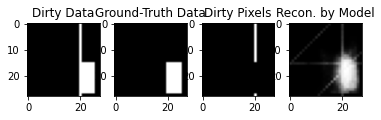

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


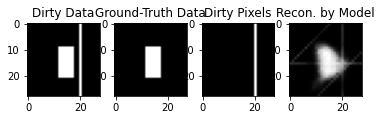

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


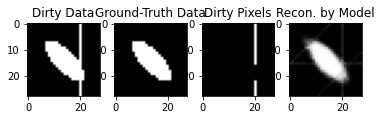

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


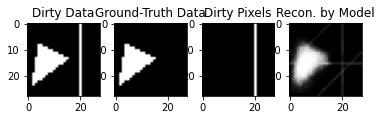

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


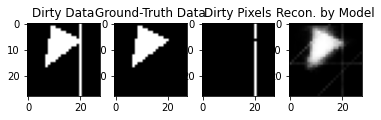

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


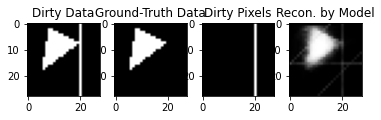

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


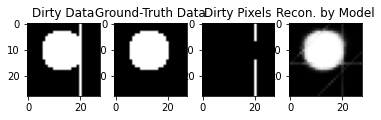

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


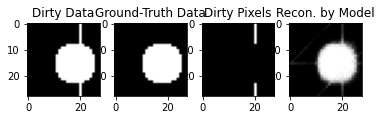

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


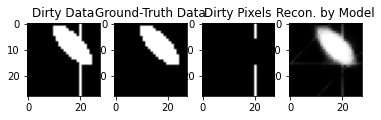

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


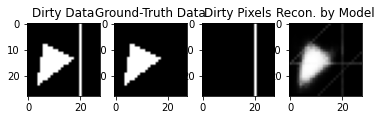







Noise Tag: 1
Noise Indices: 
[2494, 286, 3400, 1695, 3448, 1621, 2518, 3569, 3689, 3683, 1021, 1363, 651, 3134, 611, 2024, 2879, 3515, 2124, 3216, 1760, 1602, 57, 2310, 1895, 529, 2480, 3367, 3758, 561, 2178, 588, 265, 2218, 75, 1513, 1692, 329, 2666, 1250, 734, 2303, 104, 3776, 1567, 1710, 2858, 304, 1787, 3729, 2042, 3393, 345, 962, 642, 2103, 2190, 1224, 2114, 3613, 2595, 2196, 154, 3508, 3711, 2415, 938, 3421, 3, 2665, 2802, 2281, 1018, 3432, 2798, 1126, 1374, 704, 1774, 3817, 2547, 3529, 3978, 3029, 13, 1358, 632, 3910, 817, 376, 1744, 3170, 1950, 1004, 1058, 1207, 1191, 3436, 457, 2818, 650, 3809, 215, 2394, 723, 1026, 229, 2733, 2, 3771, 3233, 285, 1245, 365, 1098, 3390, 702, 2596, 3045, 3242, 2456, 1931, 1029, 320, 3466, 3405, 2829, 996, 283, 3410, 3901, 763, 1138, 237, 3088, 3617, 3681, 3065, 1801, 2874, 2900, 2931, 587, 2305, 1468, 339, 3567, 1263, 2191, 550, 2502, 3594, 66, 3025, 1707, 3899, 2187, 1533, 3462, 2070, 296, 1990, 3525, 2323, 1315, 374, 3947, 3547, 3627, 20

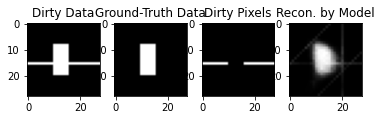

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


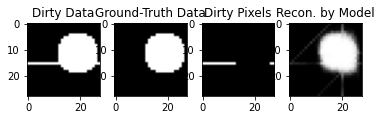

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


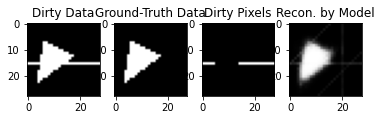

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


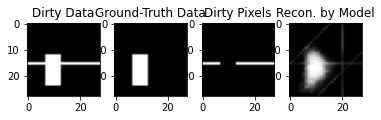

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


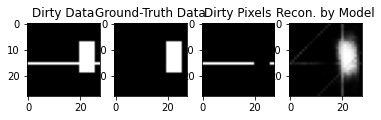

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


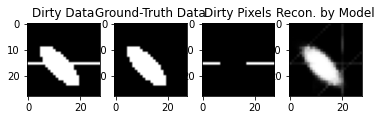

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


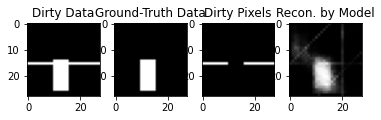

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


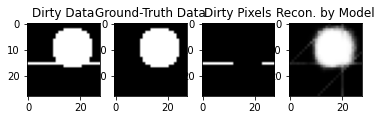

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


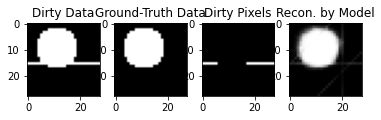

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


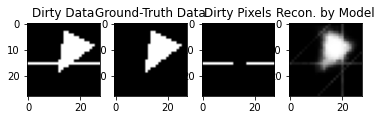







Noise Tag: 2
Noise Indices: 
[3287, 2577, 3902, 2709, 280, 640, 3014, 574, 248, 1090, 2158, 2164, 3353, 521, 24, 1549, 1412, 3243, 3222, 2021, 760, 2893, 854, 3676, 1822, 2567, 2777, 444, 2155, 3322, 1199, 2736, 212, 605, 2458, 1382, 1767, 3994, 1023, 735, 3074, 1627, 3541, 3789, 3907, 3477, 108, 731, 988, 253, 219, 3488, 1739, 488, 3153, 3274, 3812, 2847, 3517, 3111, 736, 3922, 3888, 838, 3148, 21, 382, 1401, 469, 1354, 3494, 1406, 199, 3101, 1749, 2237, 861, 244, 416, 3923, 1230, 751, 568, 3524, 732, 535, 1597, 3163, 3486, 2541, 2121, 1394, 3184, 1033, 370, 1439, 3532, 625, 3375, 3048, 786, 1463, 1994, 2232, 1091, 101, 1454, 3309, 1206, 1863, 3112, 2935, 886, 1444, 3643, 3404, 1279, 2972, 315, 148, 672, 1087, 1024, 3237, 1234, 1216, 1672, 3824, 1162, 1208, 3527, 1657, 1667, 2068, 3203, 2448, 3915, 318, 656, 943, 307, 1329, 1212, 3951, 391, 194, 816, 3411, 679, 1326, 526, 3602, 2241, 3094, 3064, 581, 1285, 281, 2591, 2606, 3461, 1591, 863, 3136, 3253, 3133, 274, 1311, 1519, 3036

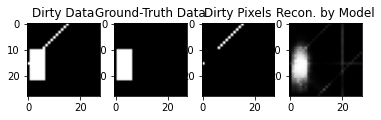

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


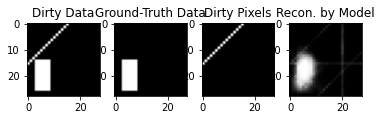

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


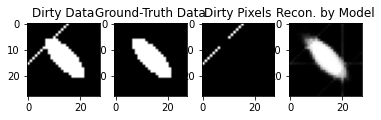

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


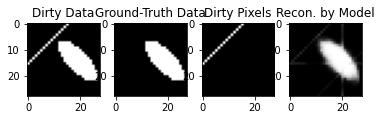

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


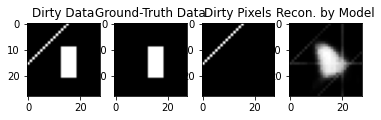

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


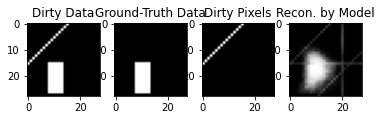

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


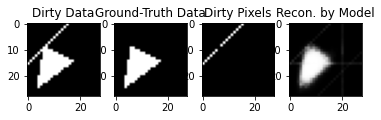

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


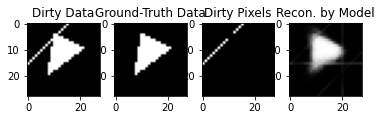

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


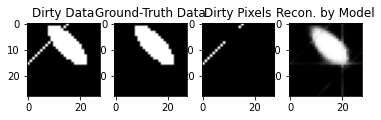

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


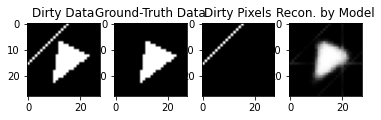







Noise Tag: 3
Noise Indices: 
[893, 202, 42, 2702, 1243, 3548, 3316, 3100, 2558, 2181, 3126, 1974, 1932, 3395, 1875, 2688, 394, 1253, 3490, 1001, 532, 3302, 3830, 684, 3697, 726, 693, 1844, 815, 1849, 870, 234, 1009, 3299, 937, 966, 1438, 2206, 1507, 2682, 1537, 2051, 1901, 2966, 1421, 3337, 3219, 3742, 1178, 2392, 810, 589, 297, 900, 2250, 2864, 1164, 3444, 3396, 2627, 2805, 2449, 2778, 3619, 2171, 3028, 873, 2548, 3572, 2797, 2538, 2435, 1289, 3024, 1802, 1645, 3612, 2212, 3763, 3956, 969, 1462, 3858, 2017, 485, 3780, 420, 3540, 3082, 951, 3853, 2721, 1046, 2511, 118, 1449, 476, 3714, 3563, 2951, 1933, 3458, 2906, 3429, 2108, 3171, 266, 68, 1214, 259, 1435, 3737, 2555, 2174, 216, 3864, 37, 3701, 1048, 317, 3657, 2497, 2285, 813, 81, 76, 3670, 842, 818, 359, 869, 565, 3652, 3290, 401, 2455, 980, 2539, 2959, 1966, 756, 1656, 609, 1176, 2221, 1028, 1980, 2139, 2960, 3531, 182, 3738, 784, 3188, 399, 2244, 2697, 245, 269, 2938, 2597, 428, 1318, 1577, 408, 1754, 1314, 1005, 3813, 3554

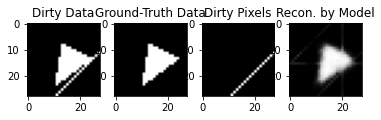

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


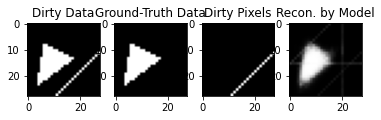

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


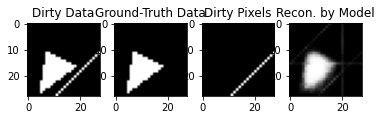

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


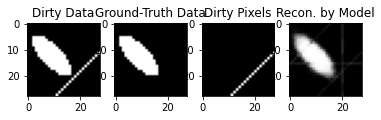

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


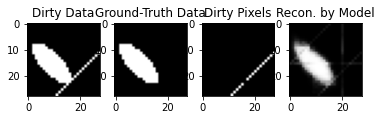

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


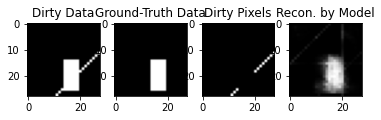

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


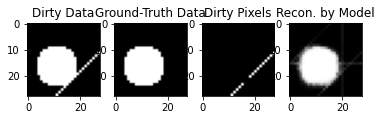

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


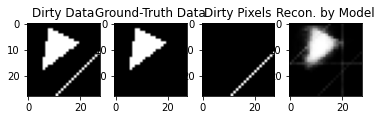

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


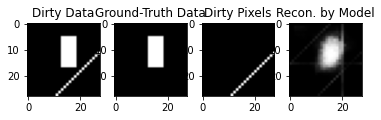

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


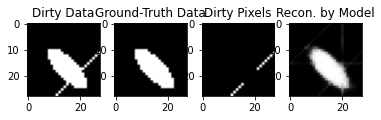

In [42]:
## show per noise type images: y_noise_lists or y_noise_dict

max_show_n = 10

for noise_key, noise_idxs in y_noise_dict_train.items():
    
    print("Noise Tag: {}".format(noise_key))
    print("Noise Indices: \n{}".format(noise_idxs))
    
    _selected_idxs = np.random.permutation(noise_idxs)[:max_show_n]
    
    for idx in _selected_idxs:
    
        print("y_class (clean): {} | y_noise: {} | y_noise_tag (noise type): {}".format(
            0, y_noise_instance_train[idx], noise_key)) # y_class_train[idx]
        fig, ax = plt.subplots(1,4)
        ax[0].imshow(x_train_orig[idx,...],cmap="gray")
        ax[0].set_title("Dirty Data")
        ax[1].imshow(x_train_clean_orig[idx,...],cmap="gray")
        ax[1].set_title("Ground-Truth Data")
        ax[2].imshow(y_noise_pixels_train[idx,...],cmap="gray")
        ax[2].set_title("Dirty Pixels")
        #ax[3].imshow(recon_imgs_train[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
        ax[3].imshow(recon_imgs_train[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
        ax[3].set_title("Recon. by Model")
        plt.show()
        
    print("\n\n\n\n\n")



### Show Trusted Set (Clean Ground-Truth, Train Data, Recon)

In [43]:
len(trusted_idxs_train)

400

y_noise: 0


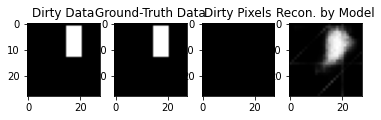

y_noise: 0


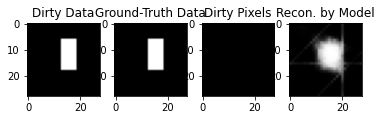

y_noise: 0


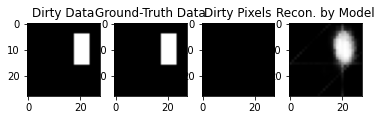

y_noise: 0


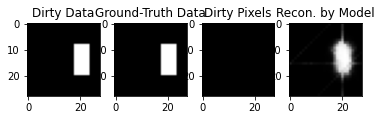

y_noise: 0


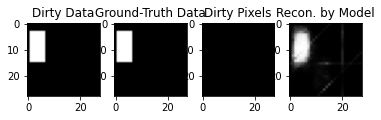

y_noise: 0


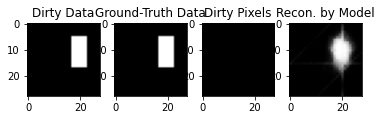

y_noise: 0


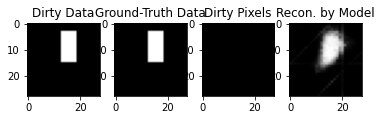

y_noise: 0


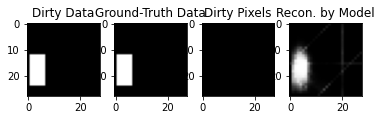

y_noise: 0


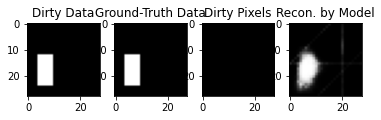

y_noise: 0


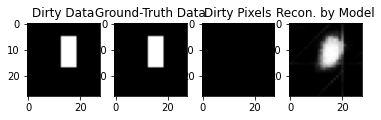

y_noise: 0


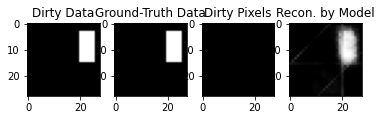

y_noise: 0


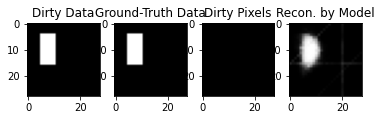

y_noise: 0


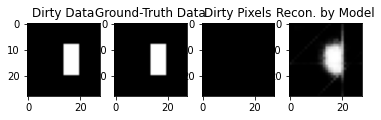

y_noise: 0


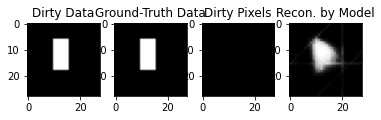

y_noise: 0


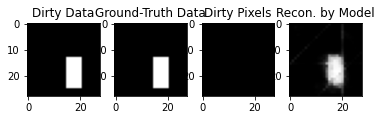

y_noise: 0


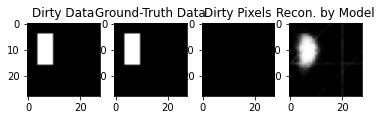

y_noise: 0


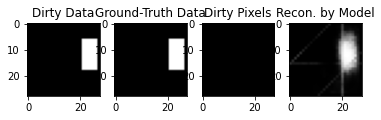

y_noise: 0


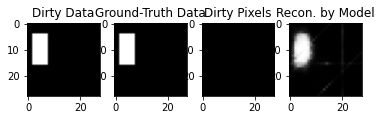

y_noise: 0


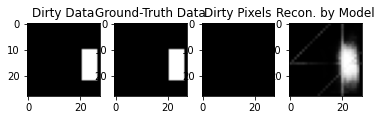

y_noise: 0


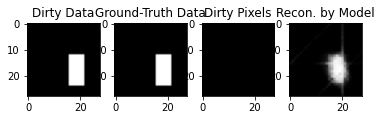

y_noise: 0


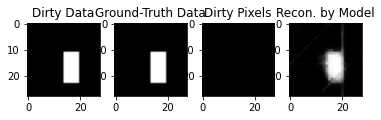

y_noise: 0


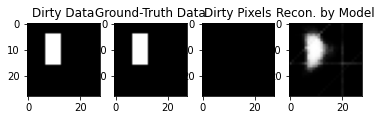

y_noise: 0


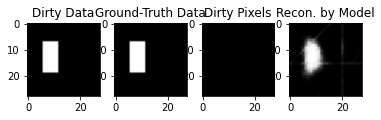

y_noise: 0


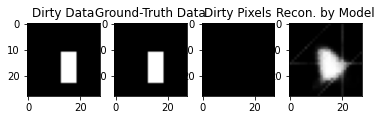

y_noise: 0


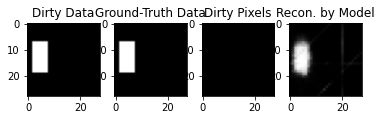

y_noise: 0


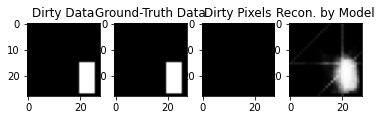

y_noise: 0


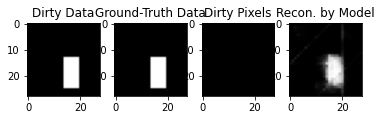

y_noise: 0


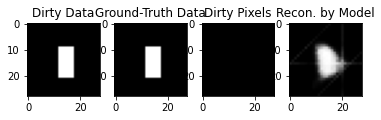

y_noise: 0


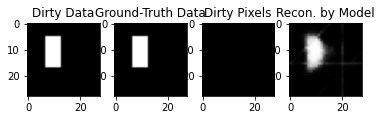

y_noise: 0


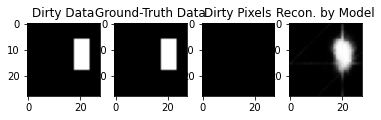

y_noise: 0


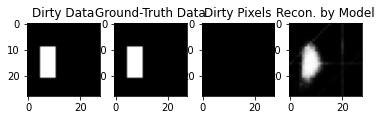

y_noise: 0


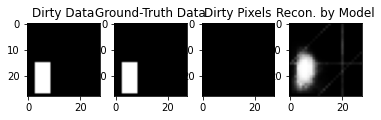

y_noise: 0


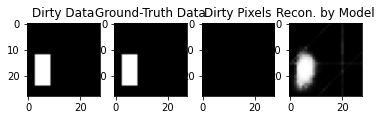

y_noise: 0


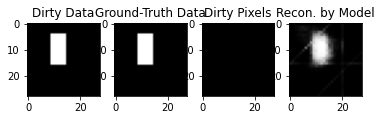

y_noise: 0


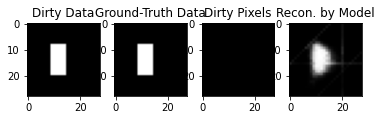

y_noise: 0


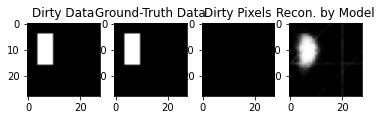

y_noise: 0


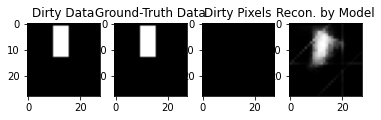

y_noise: 0


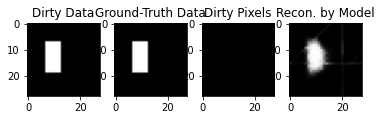

y_noise: 0


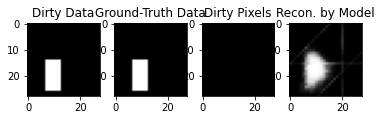

y_noise: 0


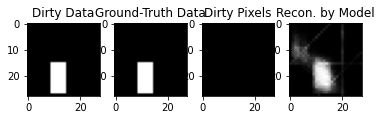

y_noise: 0


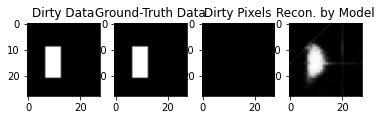

y_noise: 0


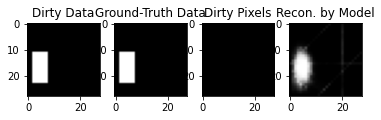

y_noise: 0


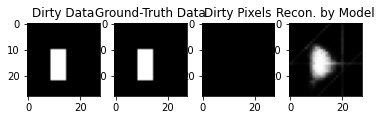

y_noise: 0


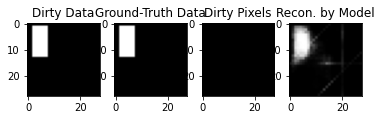

y_noise: 0


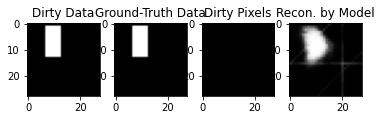

y_noise: 0


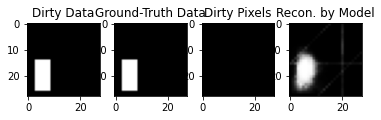

y_noise: 0


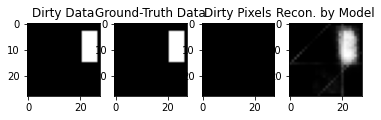

y_noise: 0


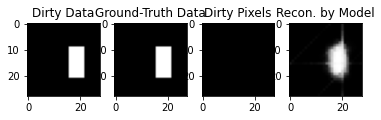

y_noise: 0


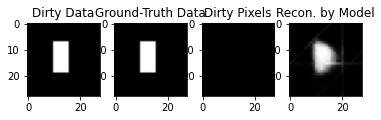

y_noise: 0


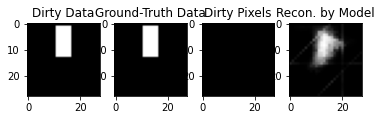

y_noise: 0


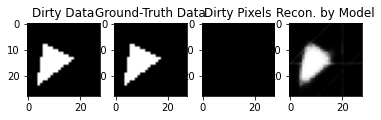

y_noise: 0


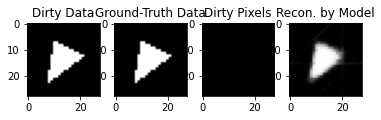

y_noise: 0


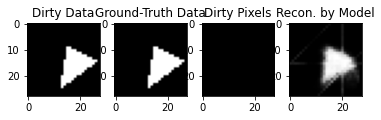

y_noise: 0


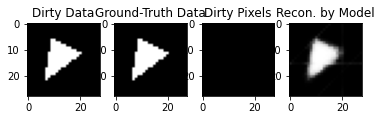

y_noise: 0


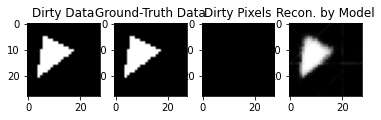

y_noise: 0


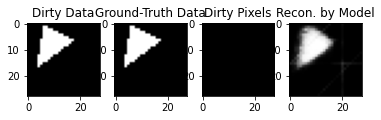

y_noise: 0


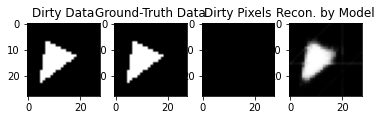

y_noise: 0


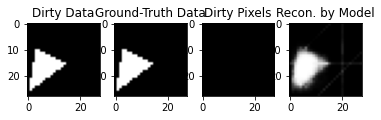

y_noise: 0


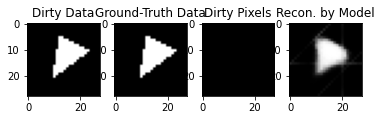

y_noise: 0


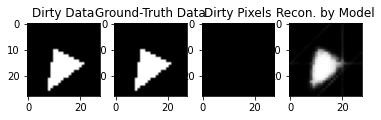

y_noise: 0


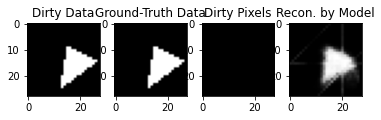

y_noise: 0


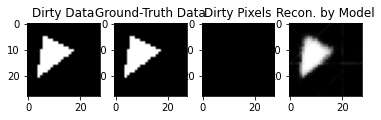

y_noise: 0


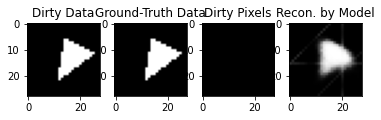

y_noise: 0


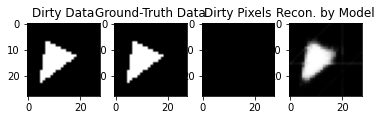

y_noise: 0


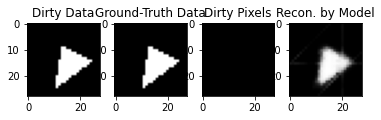

y_noise: 0


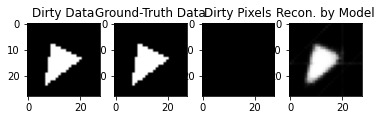

y_noise: 0


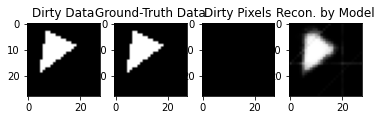

y_noise: 0


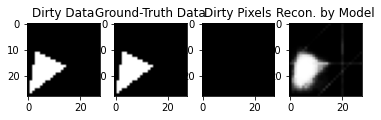

y_noise: 0


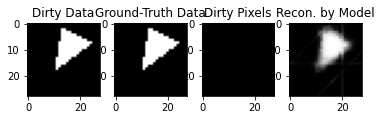

y_noise: 0


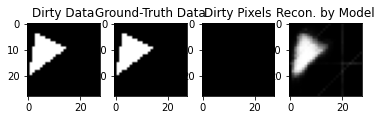

y_noise: 0


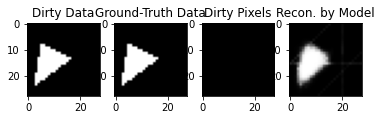

y_noise: 0


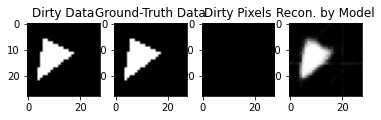

y_noise: 0


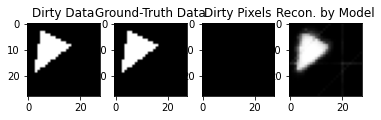

y_noise: 0


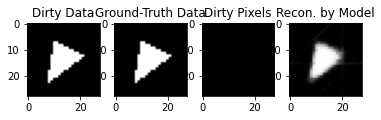

y_noise: 0


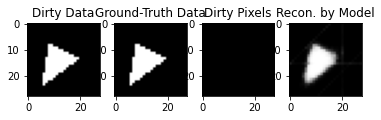

y_noise: 0


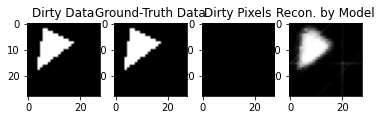

y_noise: 0


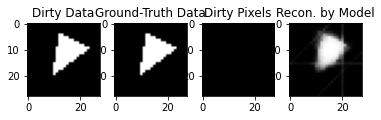

y_noise: 0


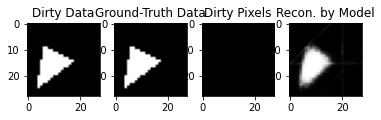

y_noise: 0


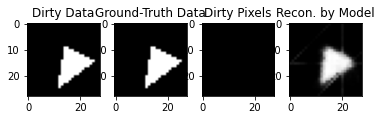

y_noise: 0


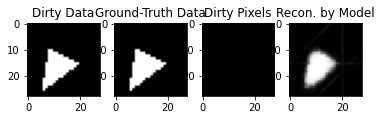

y_noise: 0


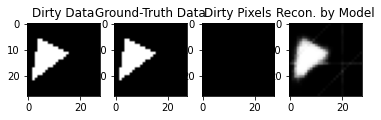

y_noise: 0


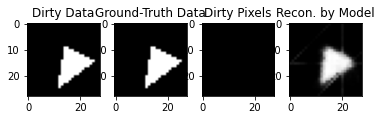

y_noise: 0


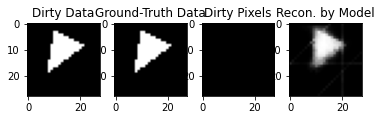

y_noise: 0


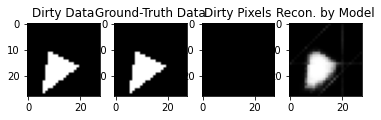

y_noise: 0


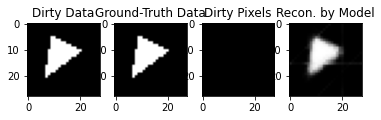

y_noise: 0


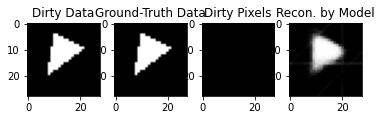

y_noise: 0


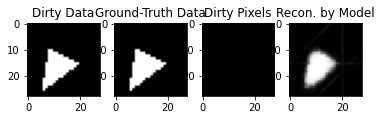

y_noise: 0


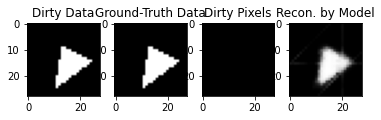

y_noise: 0


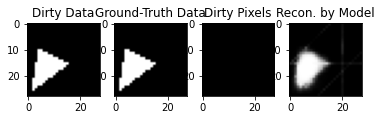

y_noise: 0


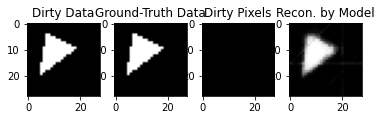

y_noise: 0


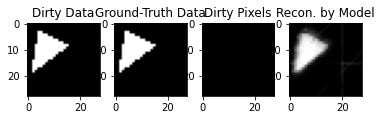

y_noise: 0


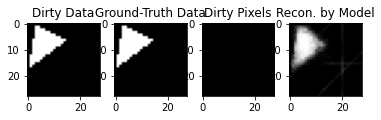

y_noise: 0


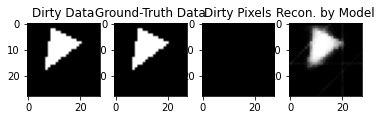

y_noise: 0


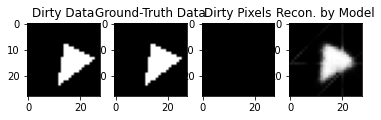

y_noise: 0


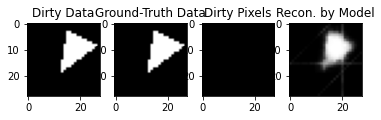

y_noise: 0


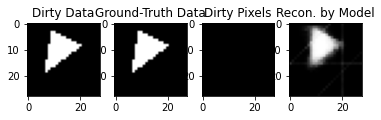

y_noise: 0


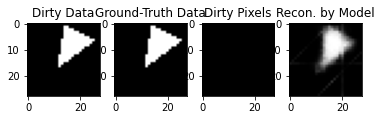

y_noise: 0


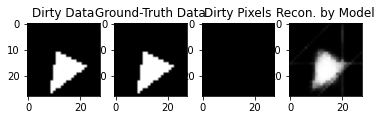

y_noise: 0


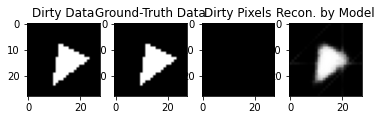

y_noise: 0


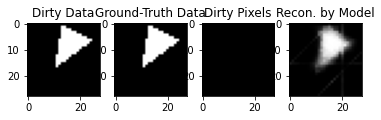

y_noise: 0


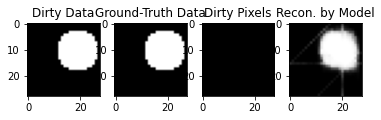

y_noise: 0


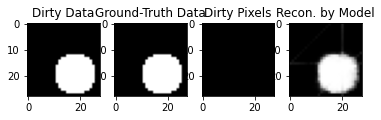

y_noise: 0


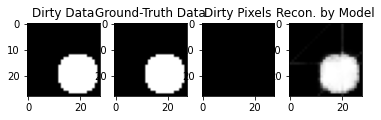

y_noise: 0


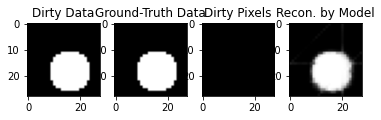

y_noise: 0


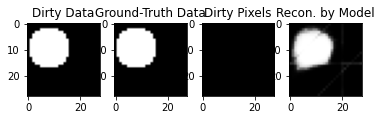

y_noise: 0


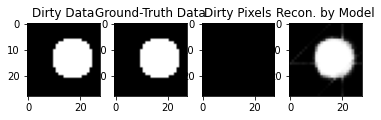

y_noise: 0


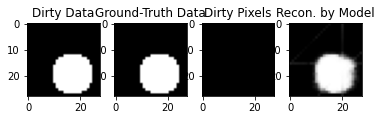

y_noise: 0


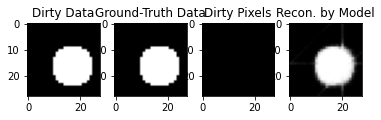

y_noise: 0


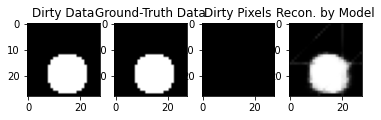

y_noise: 0


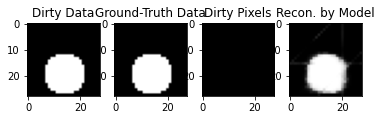

y_noise: 0


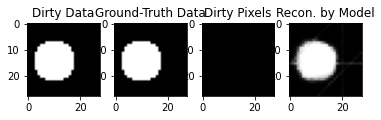

y_noise: 0


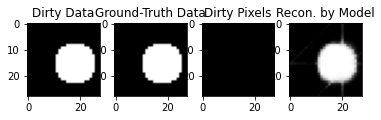

y_noise: 0


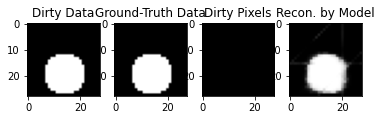

y_noise: 0


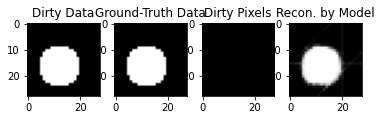

y_noise: 0


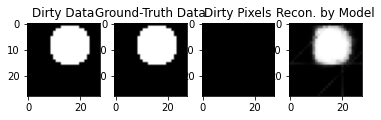

y_noise: 0


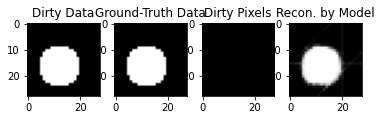

y_noise: 0


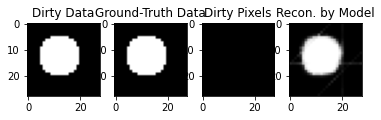

y_noise: 0


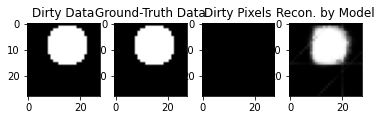

y_noise: 0


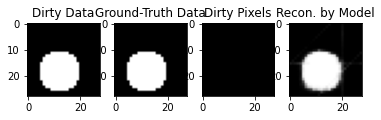

y_noise: 0


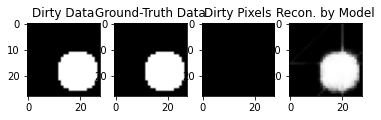

y_noise: 0


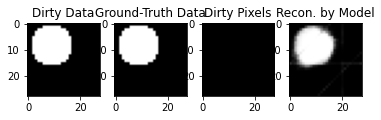

y_noise: 0


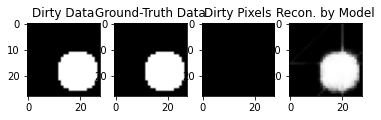

y_noise: 0


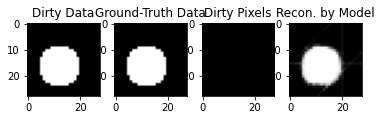

y_noise: 0


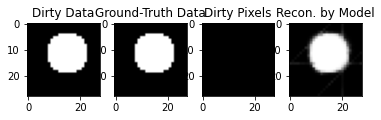

y_noise: 0


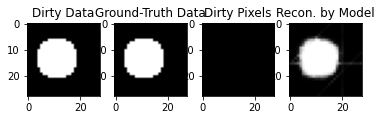

y_noise: 0


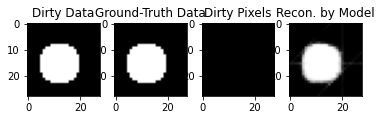

y_noise: 0


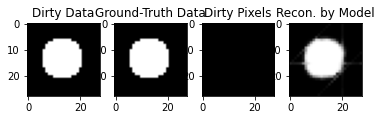

y_noise: 0


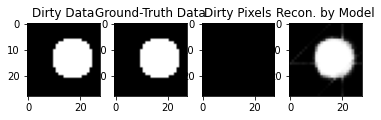

y_noise: 0


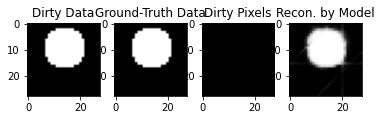

y_noise: 0


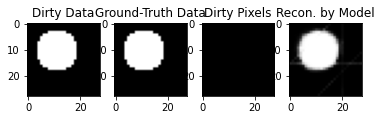

y_noise: 0


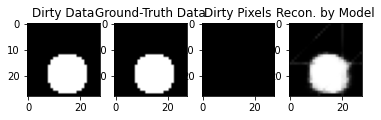

y_noise: 0


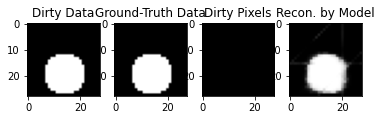

y_noise: 0


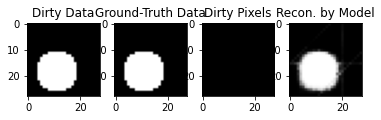

y_noise: 0


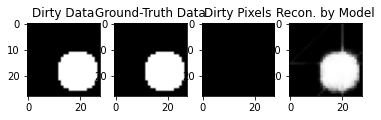

y_noise: 0


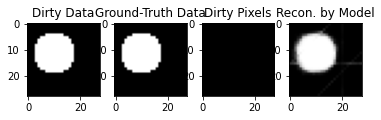

y_noise: 0


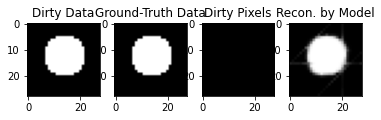

y_noise: 0


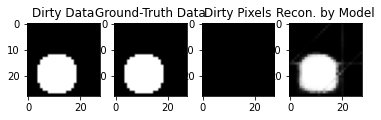

y_noise: 0


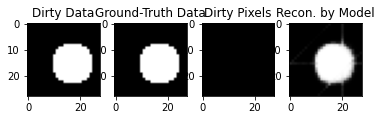

y_noise: 0


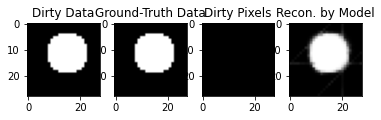

y_noise: 0


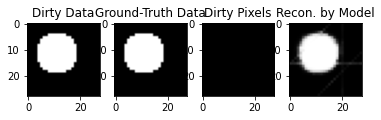

y_noise: 0


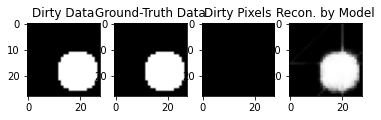

y_noise: 0


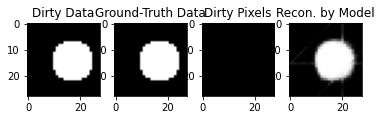

y_noise: 0


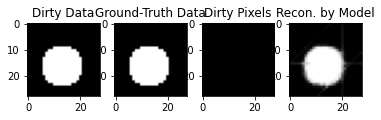

y_noise: 0


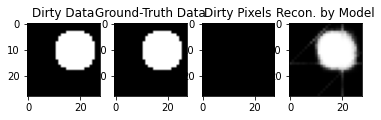

y_noise: 0


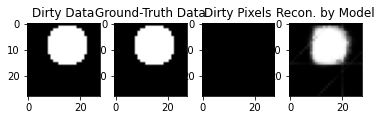

y_noise: 0


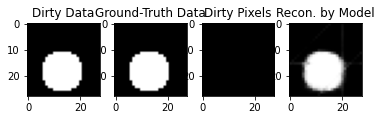

y_noise: 0


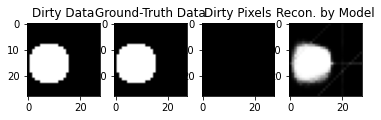

y_noise: 0


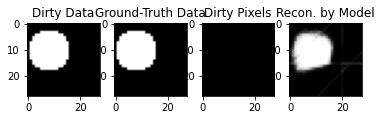

y_noise: 0


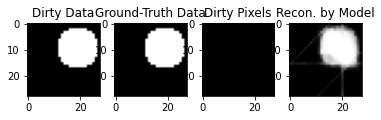

y_noise: 0


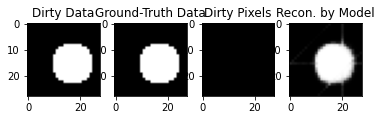

y_noise: 0


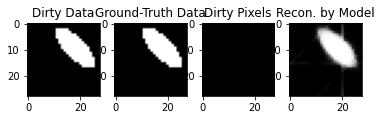

y_noise: 0


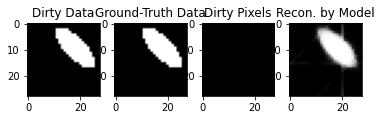

y_noise: 0


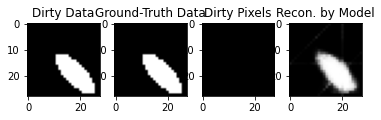

y_noise: 0


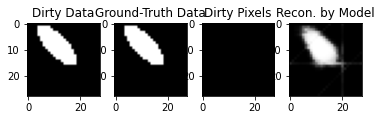

y_noise: 0


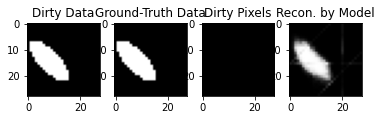

y_noise: 0


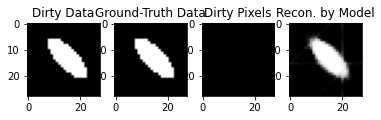

y_noise: 0


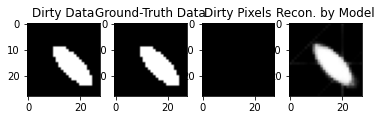

y_noise: 0


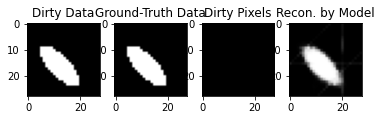

y_noise: 0


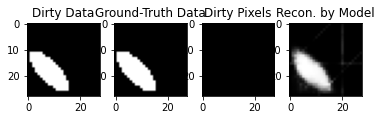

y_noise: 0


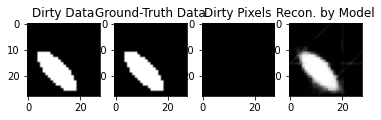

y_noise: 0


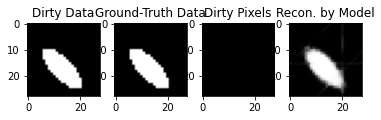

y_noise: 0


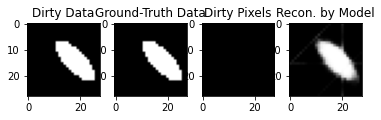

y_noise: 0


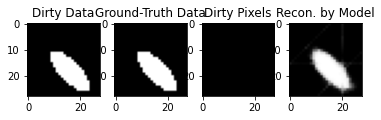

y_noise: 0


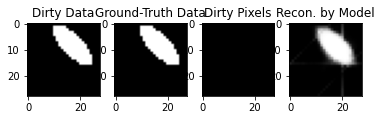

y_noise: 0


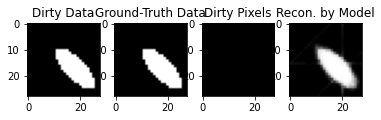

y_noise: 0


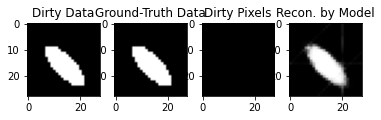

y_noise: 0


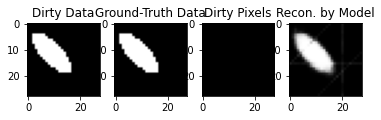

y_noise: 0


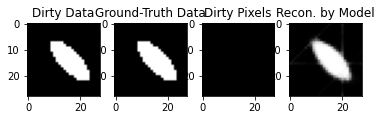

y_noise: 0


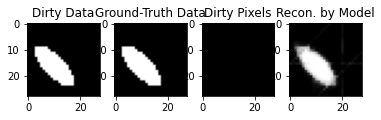

y_noise: 0


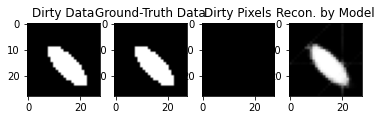

y_noise: 0


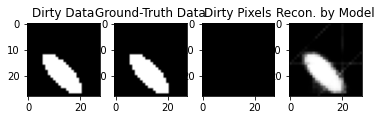

y_noise: 0


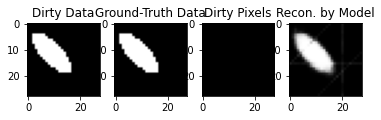

y_noise: 0


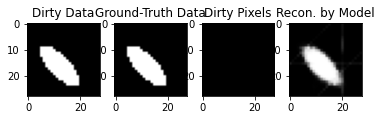

y_noise: 0


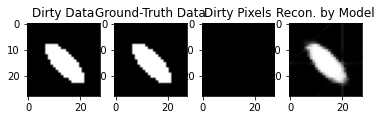

y_noise: 0


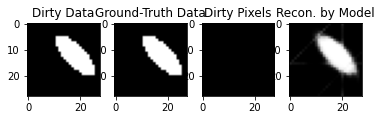

y_noise: 0


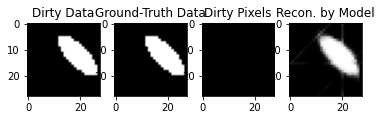

y_noise: 0


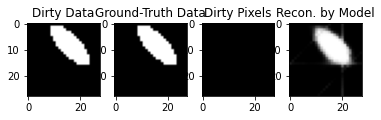

y_noise: 0


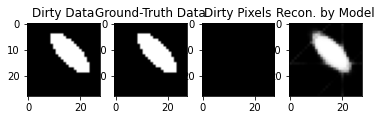

y_noise: 0


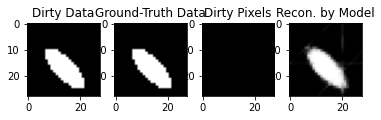

y_noise: 0


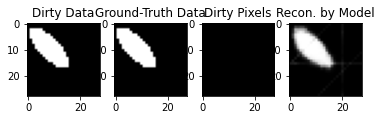

y_noise: 0


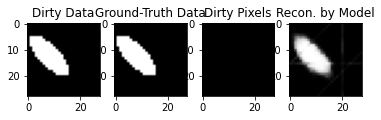

y_noise: 0


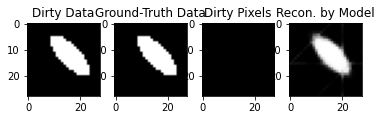

y_noise: 0


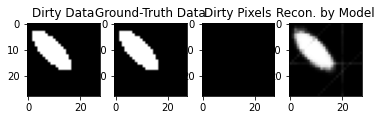

y_noise: 0


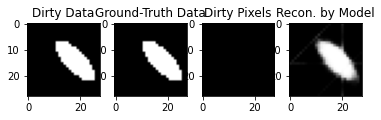

y_noise: 0


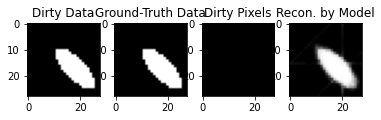

y_noise: 0


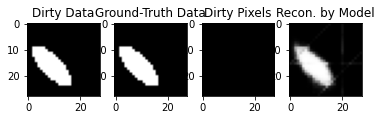

y_noise: 0


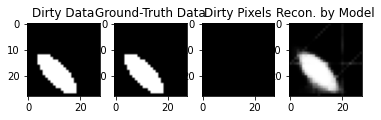

y_noise: 0


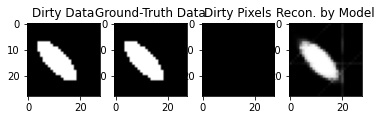

y_noise: 0


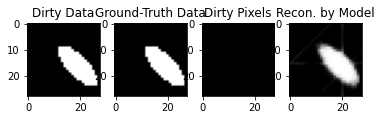

y_noise: 0


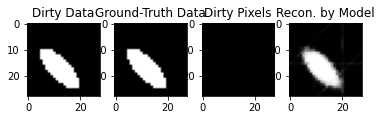

y_noise: 0


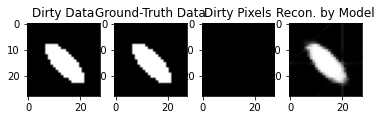

y_noise: 0


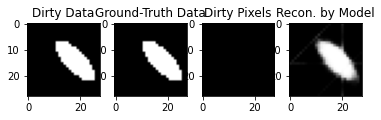

y_noise: 0


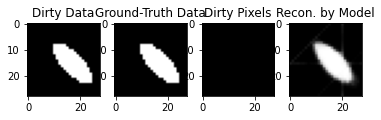

y_noise: 0


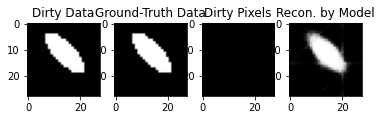

y_noise: 0


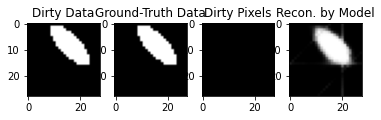

y_noise: 0


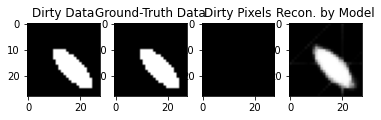

y_noise: 0


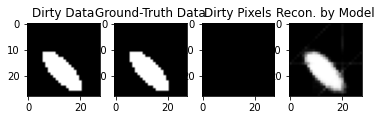

y_noise: 0


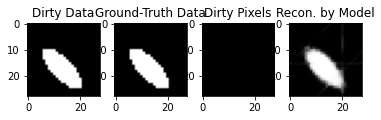

y_noise: 0


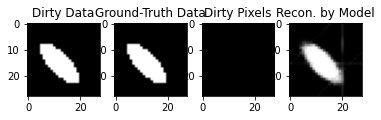

y_noise: 0


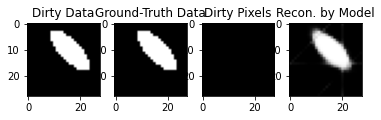

y_noise: 1


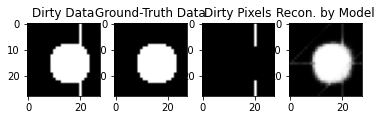

y_noise: 1


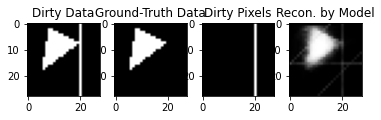

y_noise: 1


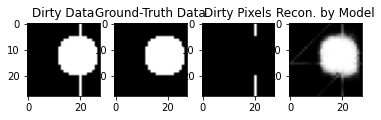

y_noise: 1


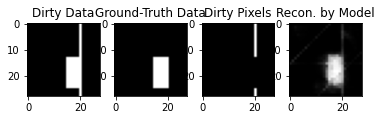

y_noise: 1


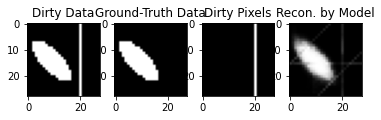

y_noise: 1


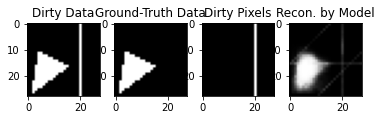

y_noise: 1


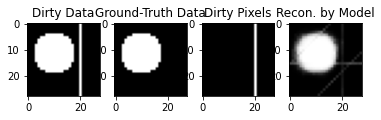

y_noise: 1


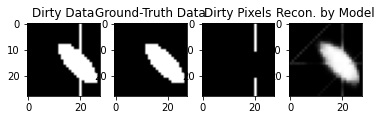

y_noise: 1


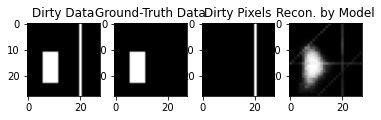

y_noise: 1


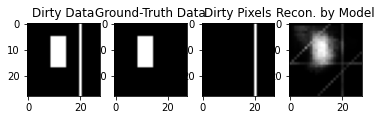

y_noise: 1


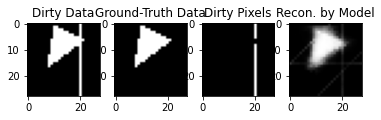

y_noise: 1


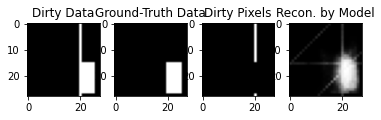

y_noise: 1


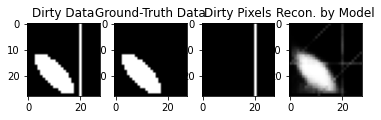

y_noise: 1


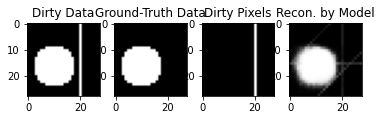

y_noise: 1


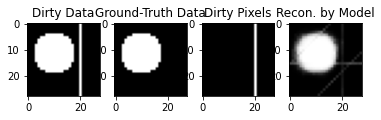

y_noise: 1


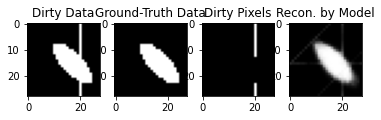

y_noise: 1


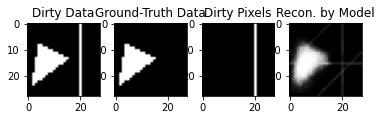

y_noise: 1


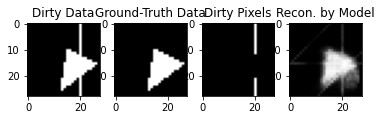

y_noise: 1


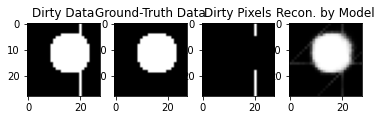

y_noise: 1


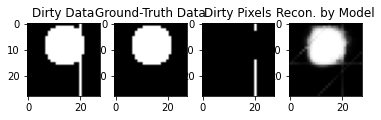

y_noise: 1


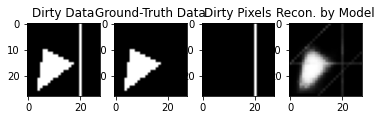

y_noise: 1


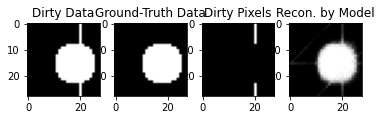

y_noise: 1


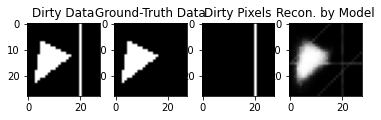

y_noise: 1


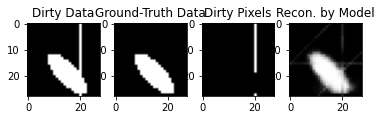

y_noise: 1


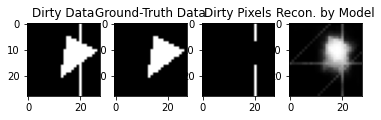

y_noise: 1


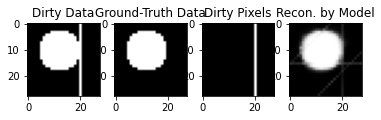

y_noise: 1


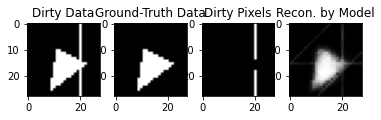

y_noise: 1


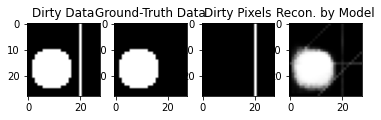

y_noise: 1


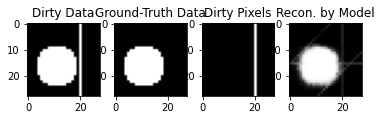

y_noise: 1


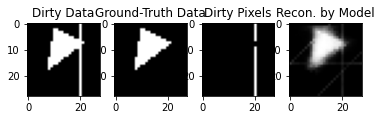

y_noise: 1


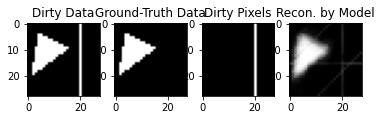

y_noise: 1


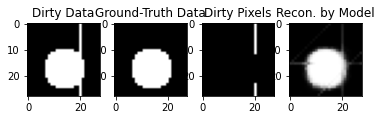

y_noise: 1


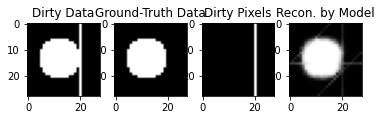

y_noise: 1


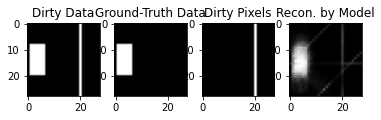

y_noise: 1


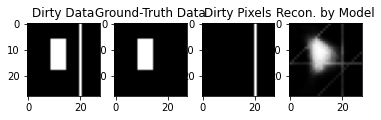

y_noise: 1


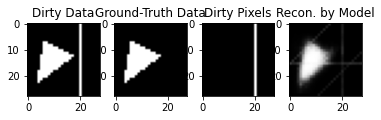

y_noise: 1


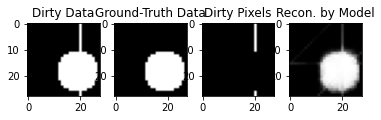

y_noise: 1


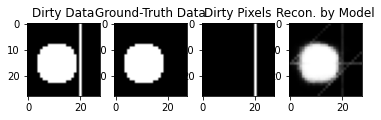

y_noise: 1


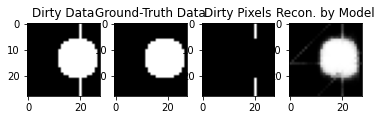

y_noise: 1


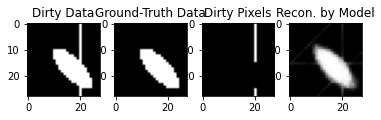

y_noise: 1


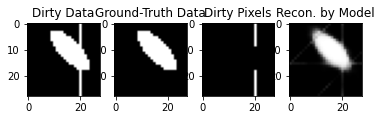

y_noise: 1


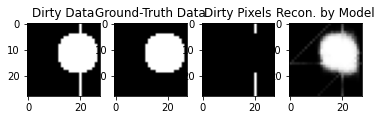

y_noise: 1


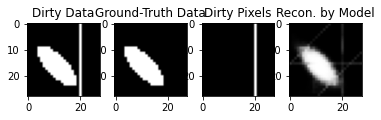

y_noise: 1


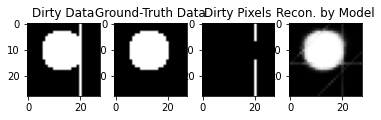

y_noise: 1


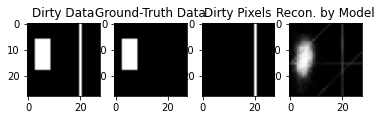

y_noise: 1


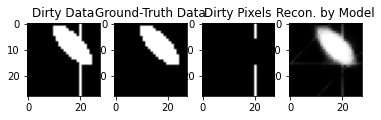

y_noise: 1


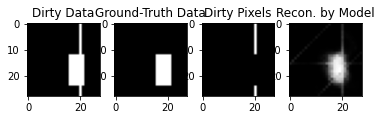

y_noise: 1


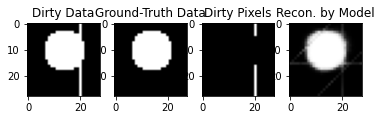

y_noise: 1


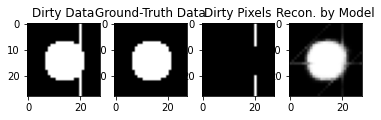

y_noise: 1


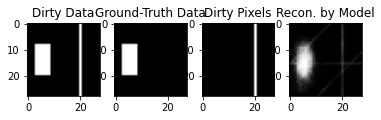

y_noise: 1


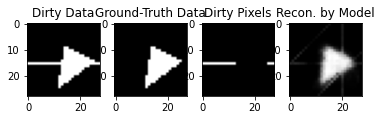

y_noise: 1


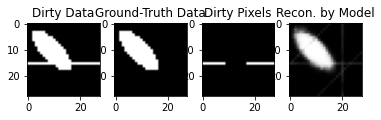

y_noise: 1


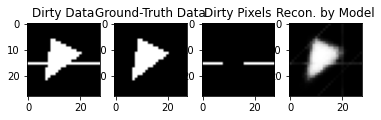

y_noise: 1


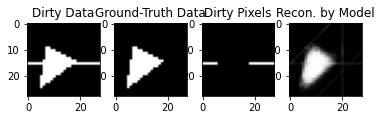

y_noise: 1


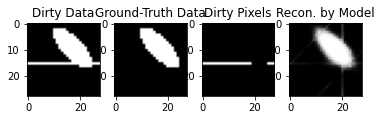

y_noise: 1


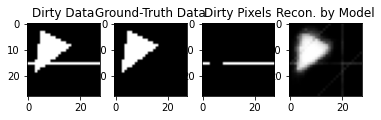

y_noise: 1


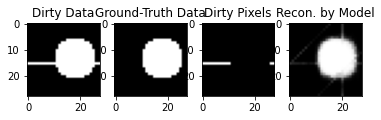

y_noise: 1


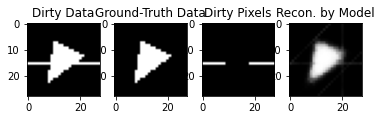

y_noise: 1


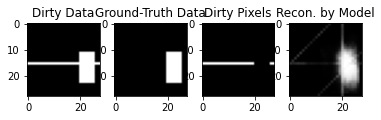

y_noise: 1


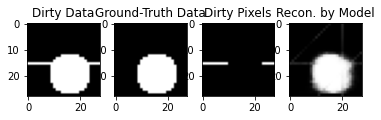

y_noise: 1


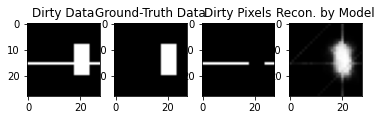

y_noise: 1


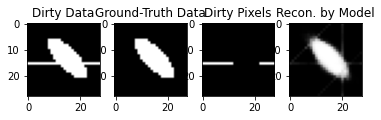

y_noise: 1


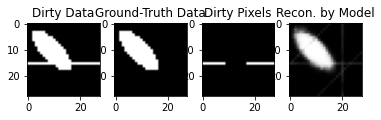

y_noise: 1


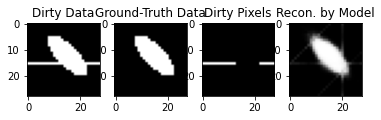

y_noise: 1


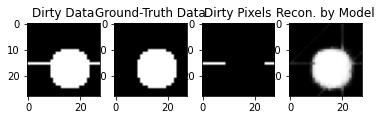

y_noise: 1


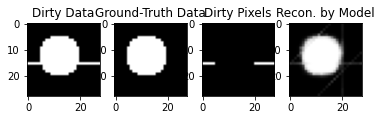

y_noise: 1


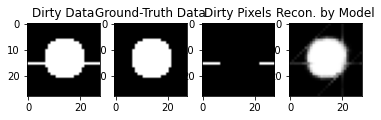

y_noise: 1


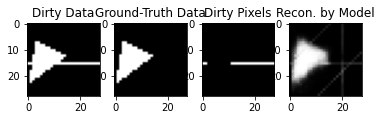

y_noise: 1


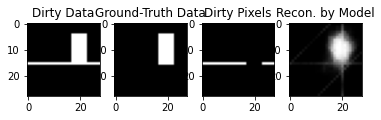

y_noise: 1


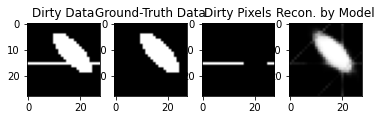

y_noise: 1


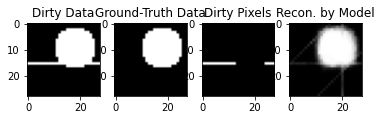

y_noise: 1


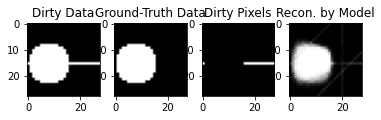

y_noise: 1


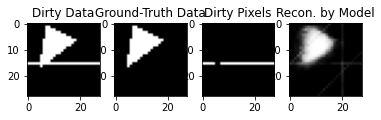

y_noise: 1


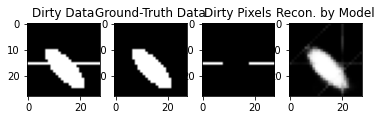

y_noise: 1


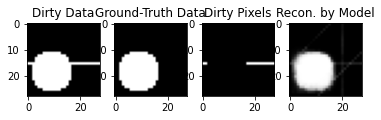

y_noise: 1


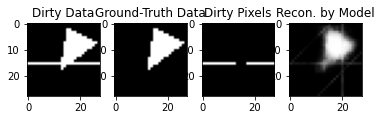

y_noise: 1


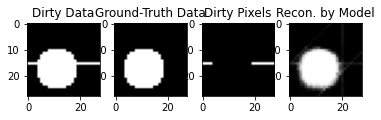

y_noise: 1


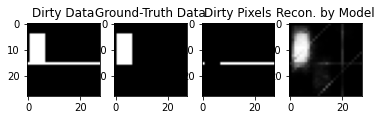

y_noise: 1


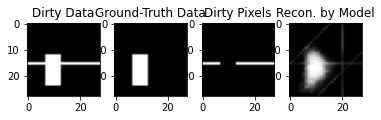

y_noise: 1


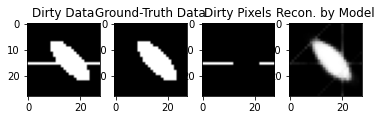

y_noise: 1


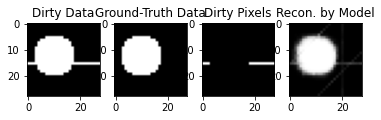

y_noise: 1


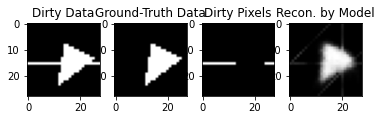

y_noise: 1


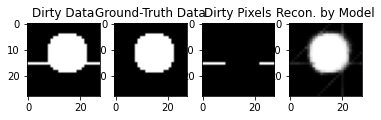

y_noise: 1


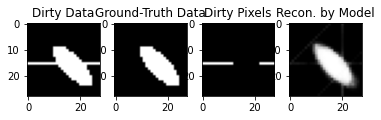

y_noise: 1


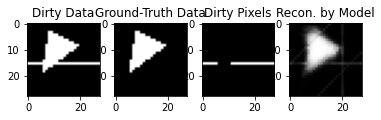

y_noise: 1


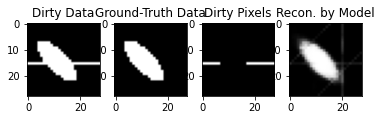

y_noise: 1


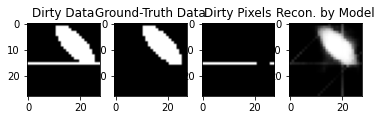

y_noise: 1


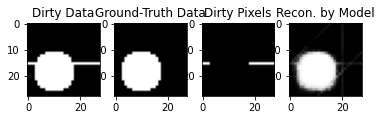

y_noise: 1


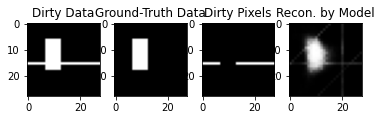

y_noise: 1


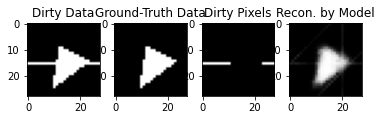

y_noise: 1


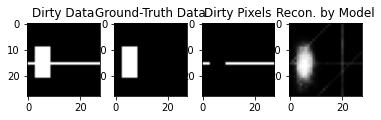

y_noise: 1


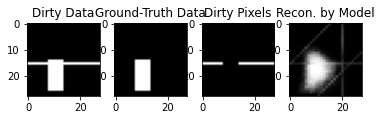

y_noise: 1


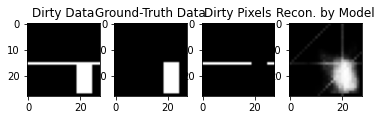

y_noise: 1


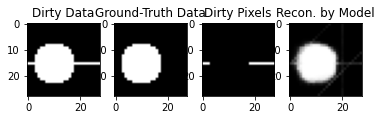

y_noise: 1


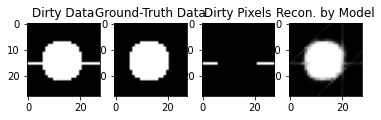

y_noise: 1


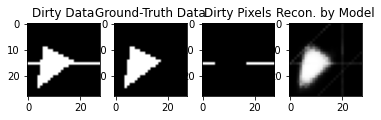

y_noise: 1


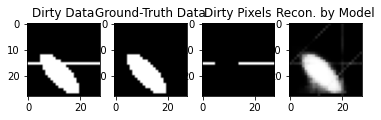

y_noise: 1


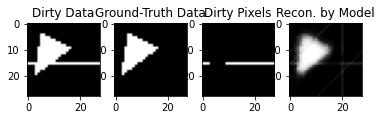

y_noise: 1


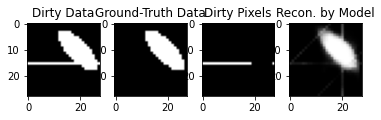

y_noise: 1


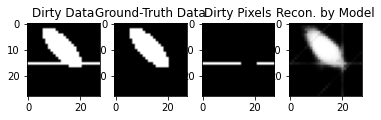

y_noise: 1


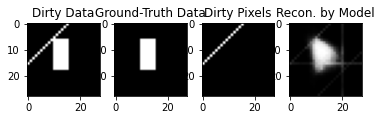

y_noise: 1


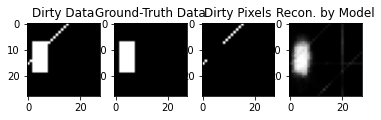

y_noise: 1


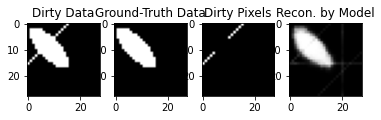

y_noise: 1


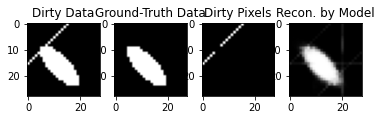

y_noise: 1


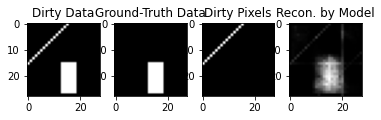

y_noise: 1


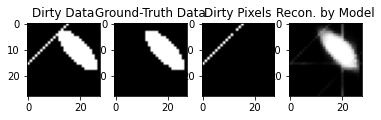

y_noise: 1


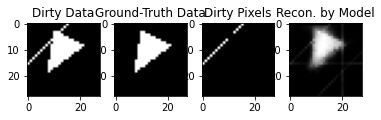

y_noise: 1


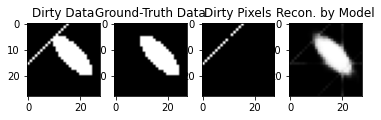

y_noise: 1


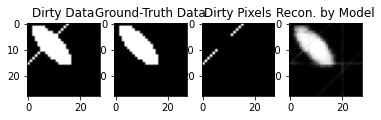

y_noise: 1


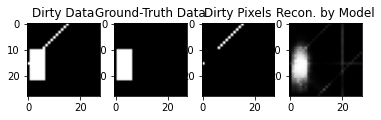

y_noise: 1


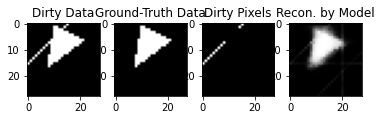

y_noise: 1


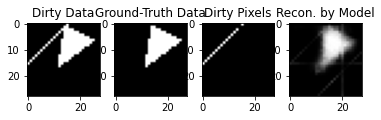

y_noise: 1


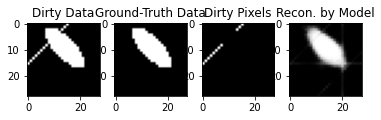

y_noise: 1


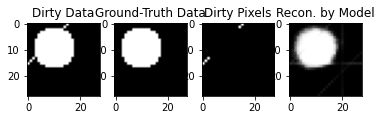

y_noise: 1


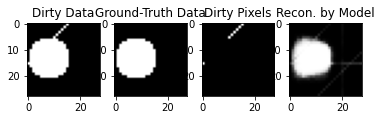

y_noise: 1


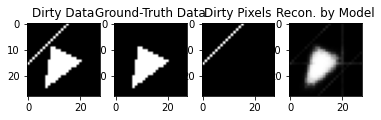

y_noise: 1


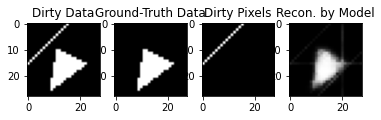

y_noise: 1


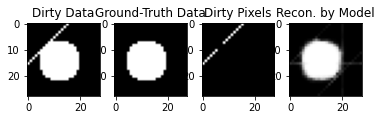

y_noise: 1


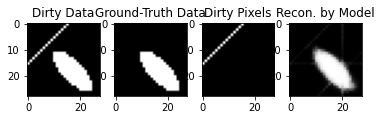

y_noise: 1


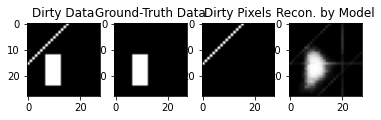

y_noise: 1


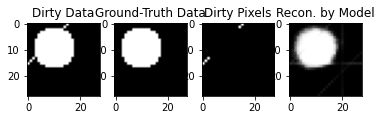

y_noise: 1


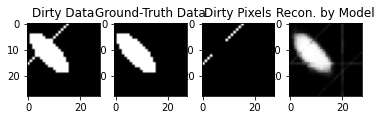

y_noise: 1


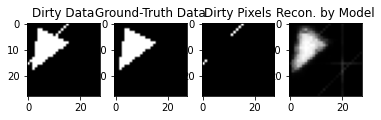

y_noise: 1


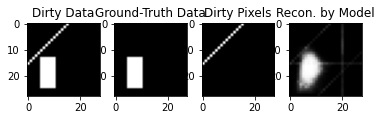

y_noise: 1


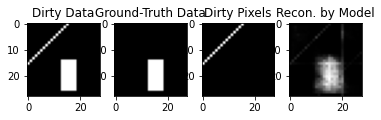

y_noise: 1


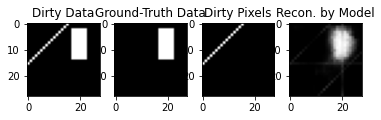

y_noise: 1


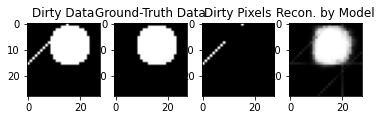

y_noise: 1


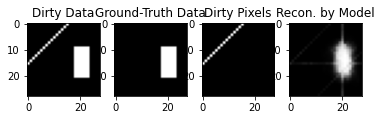

y_noise: 1


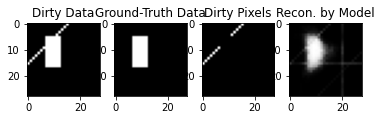

y_noise: 1


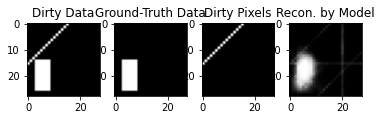

y_noise: 1


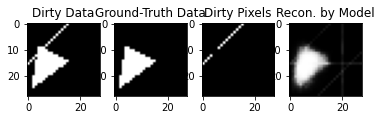

y_noise: 1


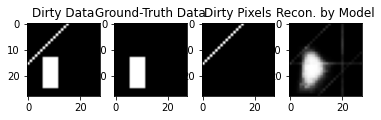

y_noise: 1


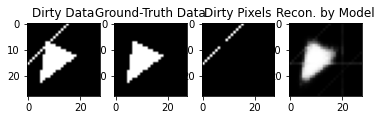

y_noise: 1


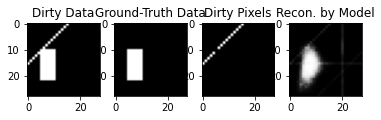

y_noise: 1


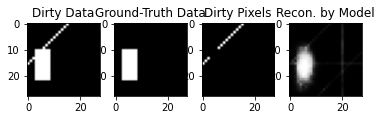

y_noise: 1


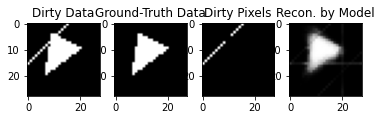

y_noise: 1


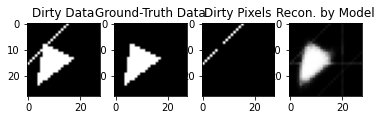

y_noise: 1


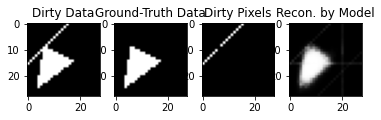

y_noise: 1


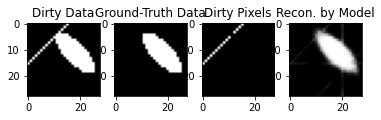

y_noise: 1


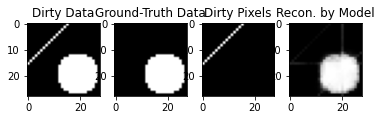

y_noise: 1


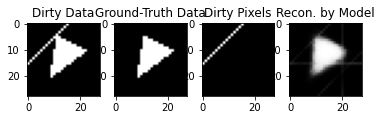

y_noise: 1


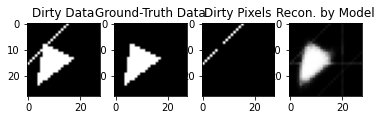

y_noise: 1


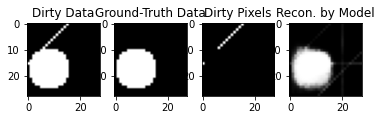

y_noise: 1


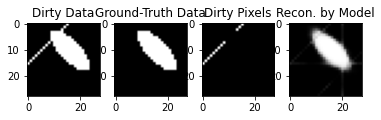

y_noise: 1


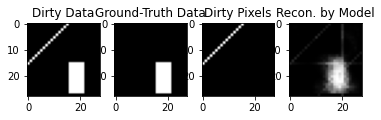

y_noise: 1


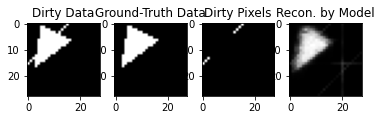

y_noise: 1


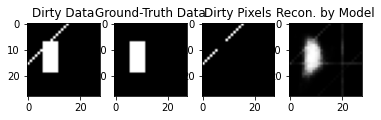

y_noise: 1


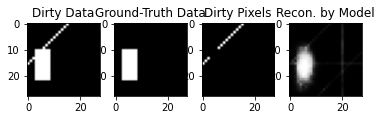

y_noise: 1


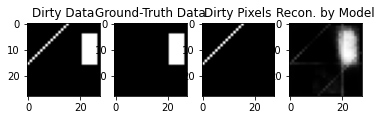

y_noise: 1


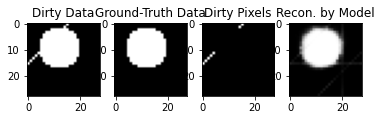

y_noise: 1


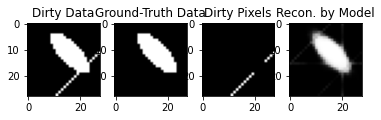

y_noise: 1


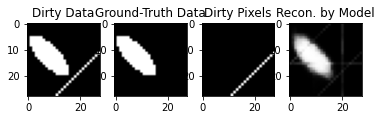

y_noise: 1


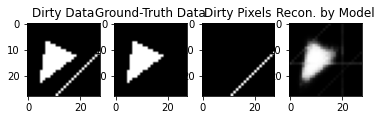

y_noise: 1


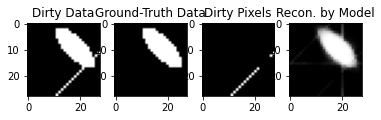

y_noise: 1


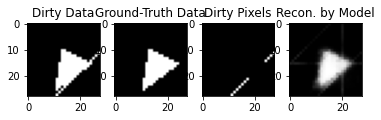

y_noise: 1


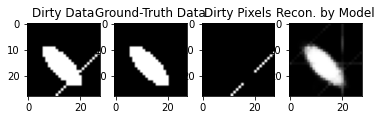

y_noise: 1


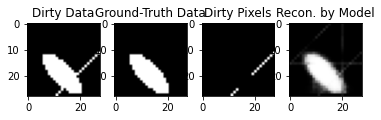

y_noise: 1


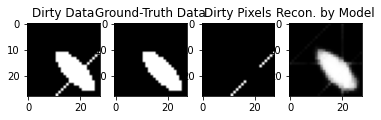

y_noise: 1


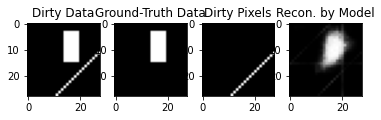

y_noise: 1


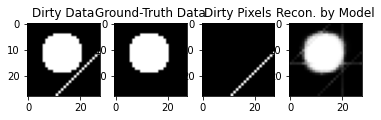

y_noise: 1


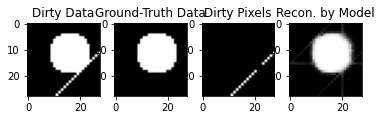

y_noise: 1


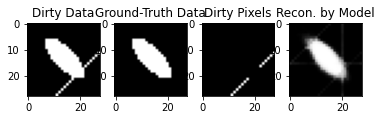

y_noise: 1


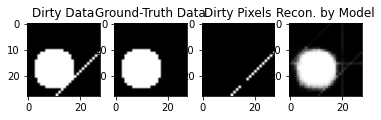

y_noise: 1


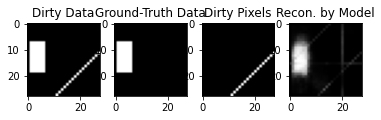

y_noise: 1


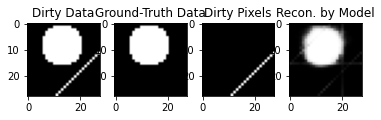

y_noise: 1


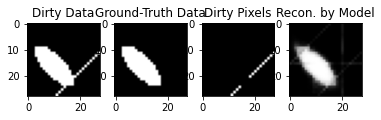

y_noise: 1


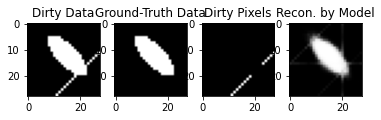

y_noise: 1


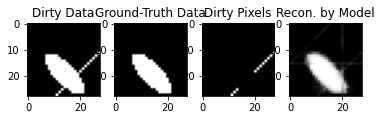

y_noise: 1


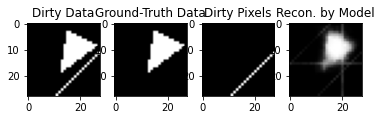

y_noise: 1


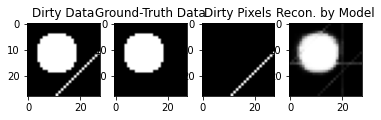

y_noise: 1


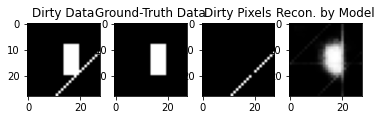

y_noise: 1


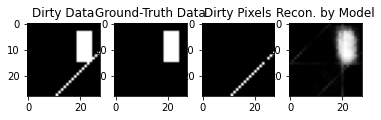

y_noise: 1


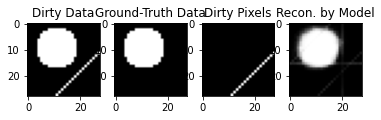

y_noise: 1


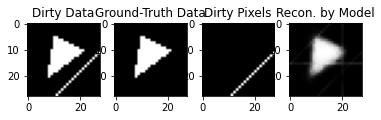

y_noise: 1


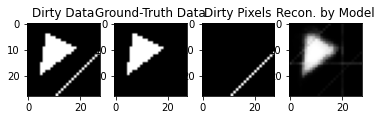

y_noise: 1


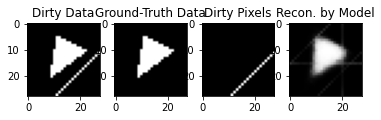

y_noise: 1


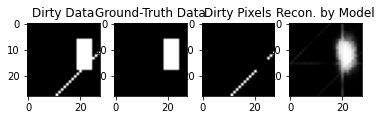

y_noise: 1


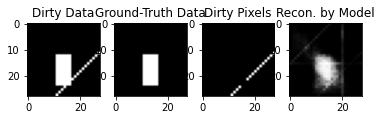

y_noise: 1


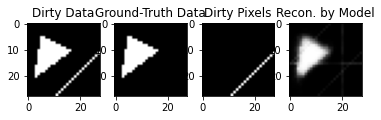

y_noise: 1


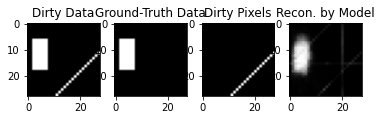

y_noise: 1


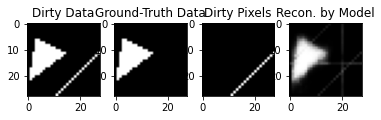

y_noise: 1


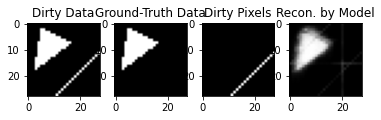

y_noise: 1


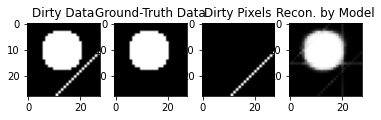

y_noise: 1


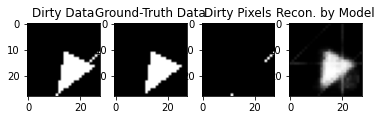

y_noise: 1


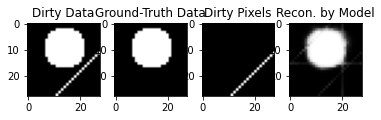

y_noise: 1


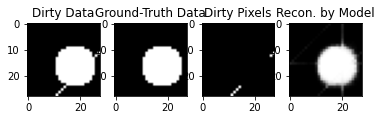

y_noise: 1


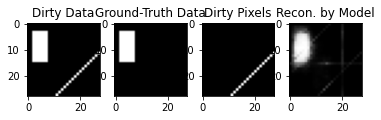

y_noise: 1


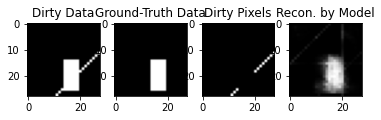

y_noise: 1


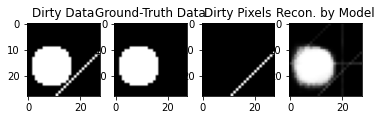

y_noise: 1


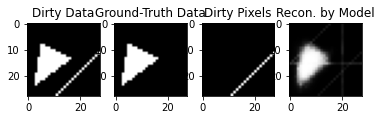

y_noise: 1


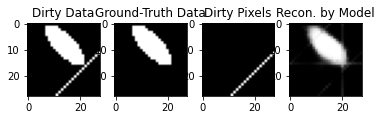

y_noise: 1


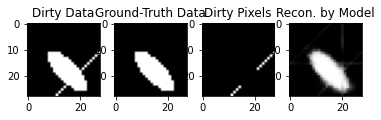

y_noise: 1


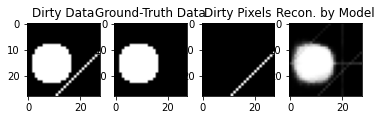

y_noise: 1


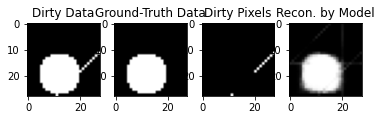

y_noise: 1


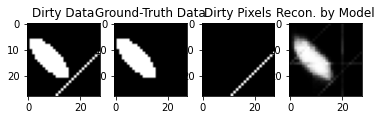

y_noise: 1


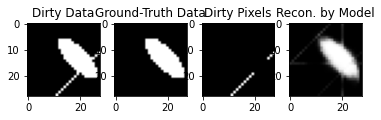

y_noise: 1


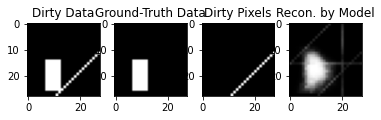

y_noise: 1


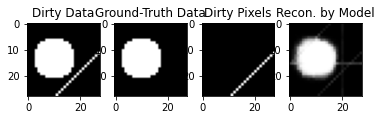

y_noise: 1


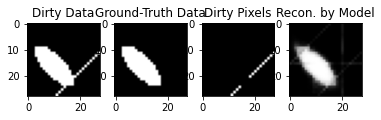

y_noise: 1


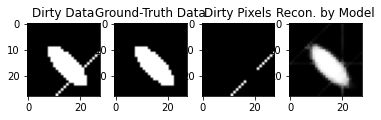

In [44]:
for idx in trusted_idxs_train:
    print("y_noise: {}".format(int(y_noise_instance_train[idx])))
    fig, ax = plt.subplots(1,4)
    ax[0].imshow(x_train_orig[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[0].set_title("Dirty Data")
    ax[1].imshow(x_train_clean_orig[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[1].set_title("Ground-Truth Data")
    ax[2].imshow(y_noise_pixels_train[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[2].set_title("Dirty Pixels")
    ax[3].imshow(recon_imgs_train[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[3].imshow(recon_imgs_train[idx,...], cmap="gray")
    ax[3].set_title("Recon. by Model")
    plt.show()


### Show Latent Space

In [45]:
noised_rows = y_noise_instance_train
noised_rows_str = ["Inlier" if not row_val else "Outlier" for row_val in noised_rows]

#### PCA

In [46]:
from sklearn.decomposition import PCA

# Use underlying clean train data for representation
pca_2d_z = PCA(n_components=2) # PCA
pca_2d_z.fit(z_train_clean)

PCA(n_components=2)

In [47]:
pca_2d_z.explained_variance_

array([4.7933145, 3.7612817], dtype=float32)

In [48]:
z_train_pca2d_clean = pca_2d_z.transform(z_train_clean)

Text(0.5, 1.0, 'Latent Space Z (Projection to 2D) for a clean q(z|x)')

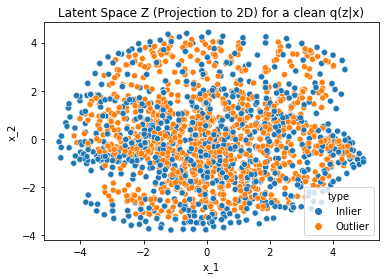

In [49]:
df_plot_z_pca2d_y1 = pd.DataFrame({"x_1": z_train_pca2d_clean[:,0], 
                                   "x_2": z_train_pca2d_clean[:,1], 
                                   "type": noised_rows_str})
sns.scatterplot(x="x_1",y="x_2",hue="type",data=df_plot_z_pca2d_y1)
plt.title("Latent Space Z (Projection to 2D) for a clean q(z|x)")

### Kernel PCA

In [50]:
from sklearn.decomposition import KernelPCA

# Use underlying clean train data for representation
kpca_2d_z = KernelPCA(n_components=2, kernel='rbf', degree=5)
kpca_2d_z.fit(z_train_clean)

KernelPCA(degree=5, kernel='rbf', n_components=2)

In [51]:
z_train_kpca2d_clean = kpca_2d_z.transform(z_train_clean)

Text(0.5, 1.0, 'Latent Space Z (Projection to 2D) for a clean q(z|x)')

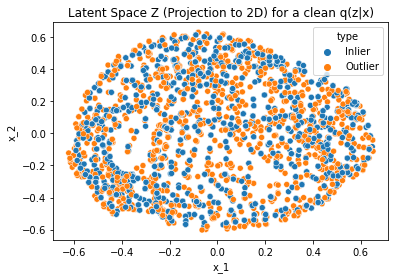

In [52]:
df_plot_z_kpca2d = pd.DataFrame({"x_1": z_train_kpca2d_clean[:,0], 
                                   "x_2": z_train_kpca2d_clean[:,1], 
                                   "type": noised_rows_str})
sns.scatterplot(x="x_1",y="x_2",hue="type",data=df_plot_z_kpca2d)
plt.title("Latent Space Z (Projection to 2D) for a clean q(z|x)")

#### T-SNE

In [53]:
from sklearn.manifold import TSNE

In [54]:
tsne_2d_z = TSNE(n_components=2, perplexity=250.0, n_iter=5000)
_z_all_2d = tsne_2d_z.fit_transform(z_train_clean)

In [55]:
_len_dataset = z_train_clean.shape[0]
z_train_tsne2d_clean = _z_all_2d

Text(0.5, 1.0, 'Latent Space Z (Projection to 2D) for a clean q(z|x)')

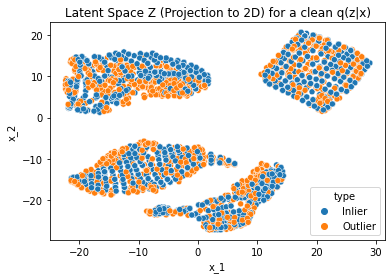

In [56]:
df_plot_z_tsne2d = pd.DataFrame({"x_1": z_train_tsne2d_clean[:,0], 
                                   "x_2": z_train_tsne2d_clean[:,1], 
                                   "type": noised_rows_str})
sns.scatterplot(x="x_1",y="x_2",hue="type",data=df_plot_z_tsne2d)
plt.title("Latent Space Z (Projection to 2D) for a clean q(z|x)")

### Approx. Log-Likelihood -- via IWAE (Importance Weighted AE Loss)

In [57]:
from repair_syserr_models.loss_utils import log_px_approx_eval

In [58]:
# TODO: insert option for cuda vs. cpu !
x_inputs = X_train.cuda()
vae_mdl.cuda();

In [59]:
with torch.autograd.profiler.profile(use_cuda=True, profile_memory=True) as prof:

    # log p(x) evaluation, for both y=1 and y=0 data
    elbo_iwae = log_px_approx_eval(vae_mdl,
                                   dataset_obj,
                                   x_inputs,
                                   k_samples=250,
                                   y_comps=False,
                                   batch_size=128)

    # to clear GPU Mem -- if used.
    log_px_est = elbo_iwae.clone().cpu()
    
    del elbo_iwae
    torch.cuda.empty_cache()


Compute Progress: 100%|█████████████████████████████████████████████| 32/32 [00:00<00:00, 39.81it/s]


In [60]:
# print(prof)

In [61]:
arrs_elbo_iwae = np.concatenate([log_px_est, y_noise_instance_train.reshape(-1,1)], axis=1)

df_elbo_iwae = pd.DataFrame(arrs_elbo_iwae, columns=["log_px", "noise_label"])
df_elbo_iwae["noise_label"] = df_elbo_iwae["noise_label"].apply(lambda x: "dirty" if x==1 else "clean")

In [62]:
df_elbo_iwae

log_px noise_label
0     -71.242348       clean
1     -51.440689       clean
2    -125.545273       dirty
3     -73.883675       dirty
4     -56.035450       clean
...          ...         ...
3995  -65.394455       clean
3996  -79.843452       clean
3997  -55.609108       clean
3998  -63.123135       clean
3999  -92.548767       dirty

[4000 rows x 2 columns]

In [63]:
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)


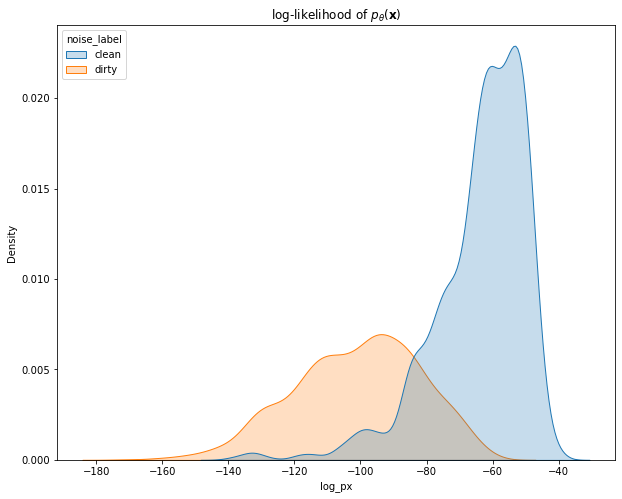

In [64]:
fig, axes = plt.subplots(1,1, figsize=(10,8))

sns.kdeplot(ax=axes, data=df_elbo_iwae, x="log_px", hue="noise_label", fill=True, legend=True)

axes.set_title("log-likelihood of $p_{\\theta}(\mathbf{x})$")
move_legend(axes, "upper left")


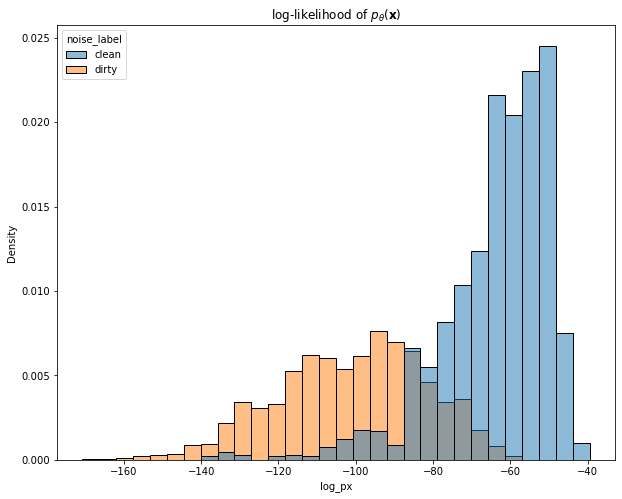

In [65]:
fig, axes = plt.subplots(1,1, figsize=(10,8))

sns.histplot(ax=axes, data=df_elbo_iwae, x="log_px", hue="noise_label", legend=True, stat="density")
axes.set_title("log-likelihood of $p_{\\theta}(\mathbf{x})$")
move_legend(axes, "upper left")


In [66]:
def epdf(xs, bins):
    xmin, xmax = np.inf, -np.inf
    for xi in xs:
        xmin = min(xmin, np.nanmin(xi))
        xmax = max(xmax, np.nanmax(xi))
    bin_range = (xmin, xmax)
    bins = np.lib.histograms.histogram_bin_edges(np.concatenate(xs), bins, bin_range)
    tops = []
    for xi in xs:
        m, _ = np.histogram(xi, bins, density=True)
        tops.append(m.astype(float))
    return tops, bins


In [67]:
tops, bin_edges = epdf([log_px_est.numpy().flatten()[~y_noise_instance_train], log_px_est.numpy().flatten()[y_noise_instance_train]], 25)
top_model, top_data = tops[0], tops[1]

In [68]:
# Earth Movers Distance (EMD)
np.sum(np.abs(top_model - top_data))

0.28132274171889143

In [69]:
def histogram_intersection(h1, h2, bins):
    bins = np.diff(bins)
    sm = 0
    for i in range(len(bins)):
        sm += min(bins[i]*h1[i], bins[i]*h2[i])
    return sm

In [70]:
# Area of intersection between the two histograms
histogram_intersection(tops[0], tops[1], bin_edges)

0.26167397652157454